# Algoritmos Genéticos

El objetivo de esta práctica es estudiar el funcionamiento de los algoritmos heurísticos no constructivos poblacionales. Este tipo de algoritmos parten de un conjunto de solución iniciales para a través de operaciones de transformación ir mejorando las soluciones candidatas. Los algoritmos que estudiar son algoritmos genéticos: básico, multimodal y CHC. Deberán compararse con los resultados de la búsqueda local del mejor vecino de la práctica 1.

Se deberá ejecutar con al menos 3 semillas. Se admitirá modificar los criterios de parada para que la ejecución del algoritmo no supere 5 minutos de ejecución por semilla en la experimentación.

## Librerías

In [37]:
import random
import copy

# Graphs and Plots
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

import statistics

import pandas as pd
import numpy as np

import os

## Parámetros

### Semillas

In [38]:
# Establecer semillas

semilla_1 = 9244889
semilla_2 = 6885052
semilla_3 = 1689685
semilla_4 = 2674794
semilla_5 = 3656827

semillas = [semilla_1, semilla_2, semilla_3, semilla_4, semilla_5]

### Precio

Precio de compra y precio de venta forman el array de 2 filas precio donde:
- precio[0] corresponde al precio_compra
- precio[1] corresponda al precio_venta

El precio se expresa en cents/kWh

In [39]:
# precio[0] = precios de compra
precio_compra_problema1 = [26, 26, 25, 24,23,24,25,27,30,29,34,32,31,31,25,24,25,26,34,36,39,40,38,29]
precio_compra_problema2= [7,7,50,25,11,26,48,45,10,14,42,14,42,22,40,34,21,31,29,34,11,37,8,50]

# precio[1] = precios de venta
precio_venta_problema1 = [24, 23, 22, 23,22,22,20,20,20,19,19,20,19,20,22,23,22,23,26,28,34,35,34,24] # 21 = max
precio_venta_problema2= [1,3,21,1,10,7,44,35,4,1,23,12,30,7,30,4,9,10,6,9,8,27,7,10]

precio_problema1 = [precio_compra_problema1, precio_venta_problema1]
precio_problema2 = [precio_compra_problema2, precio_venta_problema2]

### Radiacion
Radiacion en Wh/m2

In [40]:
# radiacion W/h en m2
radiacion_problema1 = [0, 0, 0, 0, 0, 0, 0, 0, 100, 313, 500, 661, 786, 419, 865, 230, 239, 715, 634, 468, 285, 96, 0, 0]
radiacion_problema2 = [274, 345, 605, 810, 252, 56, 964, 98, 77, 816, 68, 261, 841, 897, 75, 489, 833, 96, 117, 956, 970, 255, 74, 926]

### Problema

In [41]:
problema = "Problema 2"

if problema == "Problema 1":
    precio = precio_problema1
    radiacion = radiacion_problema1
else:
    precio = precio_problema2
    radiacion = radiacion_problema2

### Horas

In [42]:
horas = [0] * 24
for idx, hora in enumerate(horas):
    horas[idx] = idx

### Constantes

In [43]:
superficie = 1000   # m2
ganancia = 0.2  # 20%
bateria_maxima = 300 # kw                           # * 1000     # kW * 1000 = W

#### Algoritmos

In [44]:
mejor_name = "El Mejor"
algoritmo_genetico_basico_name = "AG Básico"
algoritmo_genetico_CHC_name = "AG CHC"
algoritmo_genetico_multimodal_name = "AG MultiModal"

### Resultados

In [45]:
Data = []
Algorithms_names = []

El resultado esperado es la cantidad en euros conseguida en el día, calculada como el precio por kWh vendidos en esa Hora. Dado que lo que podamos vender dependerá de la carga de la batería en dicho momento no se puede saber de antemano el resultado, por lo que el resultado será calculado mediante una simulación usando los precios y radiación. La simulación interpretará las instrucciones en la solución actual a evaluar calculando cada hora la carga de la batería y la cantidad en euros, que puede ser negativa.

## Funciones auxiliares

### Conversiones de parametros

#### Energia

In [46]:
def kw_to_w(energia_kw):
    '''
    kwh a wh
    '''

    return energia_kw * 1000

def w_to_kw(energia_w):
    '''
    w a kw
    '''

    return energia_w / 1000

In [47]:
def energia_a_porcentaje(energia):
    """
    :param energia: energia en kW
    :return porcentaje_bateria: equivalente de esos kW en porcentaje de la bateria
    """

    porcentaje_bateria = (energia / bateria_maxima) * 100

    return porcentaje_bateria


def porcentaje_a_energia(porcentaje):
    """
    :param porcentaje: equivalente de esos kW en porcentaje de la bateria
    :return energia: energia en kW
    """

    energia = (porcentaje * bateria_maxima) / 100

    return energia

#### Dinero

In [48]:
def cents_to_euros(cents):
    '''
    cents to euros
    '''

    return cents / 100

def euros_to_cents(euros):
    '''
    euro to cents
    '''

    return euros * 100

### Representación gráfica

In [49]:
def representar_grafica(dinero_hora, bateria_hora, precios_venta = precio_venta_problema1, precios_compra = precio_compra_problema1, img_name = ""):
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    dinero = host.twinx()
    bateria = host.twinx()

    offset = 5

    '''new_fixed_axis = dinero.get_grid_helper().new_fixed_axis
    dinero.axis["left"] = new_fixed_axis(loc="left", axes=dinero,
                                            offset=(0, 0))'''

    new_fixed_axis = bateria.get_grid_helper().new_fixed_axis
    bateria.axis["right"] = new_fixed_axis(loc="right", axes=bateria,
                                            offset=(offset, 0))

    host.set_xlabel("Horas")
    # host.set_ylabel("Dinero (€)")
    dinero.set_ylabel("Dinero (€)")
    bateria.set_ylabel("Bateria (%)")

    # host.set_xlim(0, 23)
    #host.set_ylim(0, 400)



    # bateria.set(ylim=(0,100))
    dinero.set(ylim=(min(dinero_hora),max(dinero_hora)))



    # Dinero acumulado en cada hora
    host.plot(horas,
             dinero_hora,
             linewidth=3,
             color='yellow',
             alpha=0.5)

    # Capacidad de la bateria en cada hora
    bat, = bateria.plot(horas,
             bateria_hora,
             color='green',
             alpha=0.8)

    # coeficiente_representacion = 1
    # Precio por hora
    dinero.plot(horas,    # eje x
             precios_venta, #[p * coeficiente_representacion for p in precios_venta],
             color='blue')

    # coeficiente_representacion = 1
    # Precio por hora
    dinero.plot(horas,    # eje x
             precios_compra, #[p * coeficiente_representacion for p in precios_venta],
             color='red')

    host.legend(["Dinero Acumulado",  "Precios de venta", "Precios de compra", "Batería"])

    bateria.axis["right"].label.set_color(bat.get_color())

    if img_name:
        plt.text(1, 13, round(dinero_hora[len(dinero_hora)-1], 2), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        plt.title(img_name)

        if not os.path.exists(img_name.split(" (")[0]):
            os.makedirs(img_name.split(" (")[0])

        plt.savefig(img_name.split(" (")[0] + "/" + problema + "/" + img_name + ".png", dpi=300, bbox_inches='tight')

    plt.show()

    return plt

In [50]:
def representar_evolucion_algoritmo(totales_dinero, totales_soluciones_peores = [], img_name = ""):
    if not totales_soluciones_peores:
        totales_soluciones_peores = totales_dinero
    # plt.figure(figsize=(20,5))
    plt.plot(range(0, len(totales_dinero)), totales_dinero, 'r')
    plt.plot(range(0, len(totales_soluciones_peores)), totales_soluciones_peores, 'b')
    plt.xlabel('Ejecucion')
    plt.ylabel('Dinero (€)')

    if img_name:
        # plt.text(1, 13, round(max(totales_dinero), 2), style='italic', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        plt.title(img_name)

        if not os.path.exists(img_name.split(" (")[0]):
            os.makedirs(img_name.split(" (")[0])

        plt.savefig(img_name.split(" (")[0] + "/" + problema + "/" + img_name + "_evolucion_" + ".png", dpi=300, bbox_inches='tight')

    plt.show()

### Otras

In [51]:
def flatten(l):
    return [item for sublist in l for item in sublist]

Los valores que queremos obtener son:
Evaluaciones = numero medio de evaluaciones realizada por el algoritmo en las cinco ejecuciones
- Evaluación media (tiempo)
- Evaluación mejor (tiempo)
- Evaluación Desviación (tiempo)
- Mejor €
- Media €
- Desviación €

## Funciones auxiliares comunes a los algoritmos

### Generar Solución Inicial

In [52]:
def solucion_aleatoria():
    # implementación de la generación de solución inicial
    solucion = [0] * 24 # Inicializar el vector con 24 ceros

    # Generar una solución válida
    for hora in range(0,24):

        numero_aleatorio = random.randint(-100,100) # Generar un num aleatorio entre el -100 y 100

        assert -100 <= numero_aleatorio <= 100, "Un numero no está en los limites"

        solucion[hora] = numero_aleatorio

    return solucion

def solucion_inicial():
    return solucion_aleatoria()

### Función Evaluación

In [53]:
def funcion_evaluacion(solucion, radiacion = radiacion, precio = precio, representar = False, img_name = ""):
    bateria_capacidad_porcentaje = 0
    dinero_total = 0

    hora_venta_pico = precio[1].index(max(precio[1]))

    # para la representacion de las funciones
    dinero_hora = [0 for _ in range(24)]
    bateria_hora = [0 for _ in range(24)]
    precios_venta = [0 for _ in range(24)]
    precios_compra = [0 for _ in range(24)]

    for hora in horas:

        # 1. Almacenar nueva energia
        energia_recibida = w_to_kw(radiacion[hora]) * superficie * ganancia  # a kwh
        bateria_capacidad_porcentaje += energia_a_porcentaje(energia_recibida)    # incrementar % de la bateria


        precio_venta_actual = precio[1][hora]
        precio_compra_actual = precio[0][hora]
        precios_venta[hora] = precio_venta_actual
        precios_compra[hora] = precio_compra_actual

        # 2. Vender si hay sobrante
        if bateria_capacidad_porcentaje > 100:
            porcentaje_bateria_sobrante = bateria_capacidad_porcentaje - 100
            bateria_capacidad_porcentaje = 100
            dinero_total += cents_to_euros((porcentaje_a_energia(porcentaje_bateria_sobrante)) * precio_venta_actual)

        # assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites"
        # assert -100 <= solucion[hora] <= 100, "Solucion hora fuera de los limites: " + str(solucion[hora])

        # print(solucion[hora])
        if solucion[hora] >= 0:  # Compra el porcentaje de batería introducido respecto a la fracción de almacenaje disponible, después de introducir la energía recibida en esa hora. Al hacer la compra sobre el porcentaje de energía almacenada tras añadir la nueva energía, solo se superará la capacidad de la batería con la nueva energía a almacenar, en este caso, esa energía sobrante se venderá.

            # 3. Comprar energia
            bateria_almacenable_porcentaje = 100 - bateria_capacidad_porcentaje # todo no puede ser menor de 0
            bateria_almacenar_porcentaje = (solucion[hora]) * bateria_almacenable_porcentaje / 100
            bateria_capacidad_porcentaje += bateria_almacenar_porcentaje

            if bateria_capacidad_porcentaje > 100:
                bateria_capacidad_porcentaje = round(bateria_capacidad_porcentaje)
                if bateria_capacidad_porcentaje > 100:
                    bateria_capacidad_porcentaje = 100

            assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites al comprar: " + str(bateria_capacidad_porcentaje)

            dinero_total -= cents_to_euros(porcentaje_a_energia(bateria_almacenar_porcentaje) * precio_compra_actual)

        else: # Vende el porcentaje de energía almacenada introducido.
            # 3. Vende energia

            bateria_vender_porcentaje = (abs(solucion[hora]) * bateria_capacidad_porcentaje) / 100

            bateria_capacidad_porcentaje -= bateria_vender_porcentaje

            if bateria_capacidad_porcentaje < 0: # pasa con numeros decimales muy pequeños por el redondeo
                bateria_capacidad_porcentaje = round(bateria_capacidad_porcentaje)

            assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites, al vender: " + str(bateria_capacidad_porcentaje)

            dinero_total += cents_to_euros((porcentaje_a_energia(bateria_vender_porcentaje)) * precio_venta_actual)

        # si es la ultima hora vender todo:
        if hora == (len(horas) - 1):
            bateria_vender_porcentaje = 100 * bateria_capacidad_porcentaje / 100

            bateria_capacidad_porcentaje -= bateria_vender_porcentaje

            dinero_total += cents_to_euros((porcentaje_a_energia(bateria_vender_porcentaje)) * precio_venta_actual)

            assert int(bateria_capacidad_porcentaje) == 0, "La batería no se ha vaciado completamente al terminar el día: " + str(bateria_capacidad_porcentaje)

        bateria_hora[hora] = bateria_capacidad_porcentaje
        dinero_hora[hora] = dinero_total

    if representar:
        representar_grafica(dinero_hora, bateria_hora, precios_venta, precios_compra, img_name)

    return dinero_total

### Movimiento

In [54]:
# se genera un numero de vecinos, por ej 40 -> elegir una posicion y hacer + / - granularidad de esa posicion, yendo de 1 en 1 o de 10 en 10
# Función para generar vecino
def generador_vecino(solucion_actual, n_vecinos = 1, granularidad = 10):
    # implementación de la generación de vecino
    vecinos = []

    for _ in [n_vecinos]:

        vecino = solucion_actual.copy()

        # incremento
        for idx, elemento in enumerate(range(len(vecino))):
            nuevo_vecino = vecino.copy()
            nuevo_valor = vecino[idx] + granularidad

            if not(-100 <= nuevo_valor <= 100):
                if nuevo_valor <= -100:
                    nuevo_valor = -100
                elif 100 <= nuevo_valor:
                    nuevo_valor = 100

            nuevo_vecino[idx] = nuevo_valor

            # Se comprueba que el número resultante esté dentro del rango [-100, 100]
            # vecino[idx] = max(min(vecino[idx], 100), -100)

            #Para evitar que pueda haber valores por encima de 100 (porque es suma), si es +100 -> no appendiza el valor
            if -100 <= nuevo_vecino[idx] <= 100:
                vecinos.append(nuevo_vecino)
                assert -100 <= nuevo_vecino[idx] <= 100, "Vecino fuera de los limites: " + str(nuevo_vecino[idx])

        # decremento
        for idx, elemento in enumerate(range(len(vecino))):
            nuevo_vecino = vecino.copy()
            nuevo_valor = vecino[idx] - granularidad
            nuevo_vecino[idx] = nuevo_valor

            # Se comprueba que el número resultante esté dentro del rango [-100, 100]
            # vecino[idx] = max(min(vecino[idx], 100), -100)
            # vecinos.append(vecino)

            #Para evitar que pueda haber valores por debajo de -100 (porque es resta), si es -100 -> no appendiza el valor
            if nuevo_vecino[idx] >= -100:
                vecinos.append(nuevo_vecino)
                assert -100 <= nuevo_vecino[idx] <= 100, "Vecino fuera de los limites: " + str(nuevo_vecino[idx])

        # vecinos.append(vecino)

    return vecinos

### Función auxiliar de evaluación

In [55]:
def evaluar_algoritmo(algorithm_name, parametros = []):
    Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor Dinero", "Ev. Medias Mejor"]

    Ev = []
    Dinero = []

    Data = []

    for semilla in semillas:
        random.seed(semilla)

        sol_inicial = solucion_inicial()

        if algorithm_name == mejor_name:
            solucion, contador_evaluaciones, totales_dineros, totales_soluciones_peores = busqueda_local_mejor(max_evaluaciones=parametros[0], solucion_inicial=sol_inicial, granularidad = parametros[1])

            img_name = str(algorithm_name + " (" + str(parametros[0]) + " max. eval.) (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, totales_soluciones_peores, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)

        elif algorithm_name == algoritmo_genetico_basico_name:
            # n_individuos, max_iteraciones, porcentaje_torneo
            solucion, contador_evaluaciones, totales_dineros, totales_soluciones_peores = algoritmo_genetico_basico(n_individuos=parametros[0], max_iteraciones=parametros[1], max_iteraciones_sin_mejora=parametros[2], porcentaje_torneo=parametros[3], prob_mutacion = parametros[4])

            img_name = str(algorithm_name + " (Individuos " + str(parametros[0]) + ") (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, totales_soluciones_peores, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)


        elif algorithm_name == algoritmo_genetico_CHC_name:
            # n_individuos, max_iteraciones, porcentaje_torneo
            solucion, contador_evaluaciones, totales_dineros, totales_soluciones_peores = algoritmo_genetico_chc(n_individuos=parametros[0], max_iteraciones=parametros[1], tamano_nuevo=parametros[2], distancia_maxima=parametros[3], umbral_reinicializaciones=parametros[4])

            img_name = str(algorithm_name + " (Individuos " + str(parametros[0]) + ") (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, totales_soluciones_peores, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)


        elif algorithm_name == algoritmo_genetico_multimodal_name:
            solucion, contador_evaluaciones, totales_dineros, totales_soluciones_peores = algoritmo_genetico_multimodal(n_individuos=parametros[0], max_iteraciones=parametros[1], max_iteraciones_sin_mejora=parametros[2], porcentaje_torneo=parametros[3], n_nichos=parametros[4], prob_mutacion=parametros[5], radio = parametros[6])

            img_name = str(algorithm_name + " (Individuos " + str(parametros[0]) + ") (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, totales_soluciones_peores, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)

        else:
            solucion, contador_evaluaciones, totales_dineros, totales_soluciones_peores = busqueda_local_mejor(max_evaluaciones=parametros[0], solucion_inicial=sol_inicial, granularidad = parametros[1])

            img_name = str(algorithm_name + " (" + str(parametros[0]) + " max. eval.) (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, totales_soluciones_peores, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)



        # print("Dinero total: " + str(dinero_total))

        # print(contador_evaluaciones[0], len(totales_dineros))

        # assert contador_evaluaciones[0] == len(totales_dineros), "El número de evaluaciones (" + str(contador_evaluaciones[0]) + ") no coincide con el número de resultados (" + str(len(totales_dineros)) + ")"

        # Ev.
        Ev.append(contador_evaluaciones)
        # €
        Dinero.append(totales_dineros)

    # print(Ev)

    # Ev = flatten(Ev)
    Dinero_flat = flatten(Dinero)

    # inicio = 0
    # fin = inicio
    lista_idx_dinero_max = []
    lista_dinero_max = []

    for idx, semilla in enumerate(semillas):
        # inicio = fin
        # fin = fin + Ev[idx]

        dinero_iteracion_actual = Dinero[idx]

        idx_max_dinero_iteracion_actual = dinero_iteracion_actual.index(max(dinero_iteracion_actual))
        lista_dinero_max.append(max(dinero_iteracion_actual))
        lista_idx_dinero_max.append(idx_max_dinero_iteracion_actual)

    # print(Ev)
    # print(lista_dinero_max)


    # 0 Ev. Medias
    Data.append(statistics.median(Ev))
    #Data.append(contador_evaluaciones)

    # 1 "Ev. Mejor" -> mide la covergencia
    # Data.append(Dinero.index(max(Dinero)))
    Data.append(min(Ev))

    # 2 "Ev. Desviación" -> mide la robustez, a mayor cercania a 0 mayor robustez
    # Data.append(statistics.stdev(Ev))
    Data.append(statistics.stdev(Ev))

    # 3 "Mejor €"
    Data.append(max(Dinero_flat))

    # 4 "Media €"
    # Data.append(statistics.median(Dinero))
    Data.append(statistics.median(lista_dinero_max))

    # 5 "Desviación €"
    # Data.append(statistics.stdev(Dinero))
    Data.append(statistics.stdev(lista_dinero_max))

    # 6 "Ev. Mejor Dinero"
    # Data.append(Dinero.index(max(Dinero)))
    semilla_ev_dinero_max = lista_dinero_max.index(max(lista_dinero_max))
    Data.append(str(semilla_ev_dinero_max + 1) + ": " + str(lista_idx_dinero_max[semilla_ev_dinero_max]))

    # 7 Ev. Medias para encontrar mejor solucion
    Data.append(statistics.median(lista_idx_dinero_max))

    for idx, dat in enumerate(Data):
        if idx != 6: Data[idx] = round(dat,2)

    print(pd.DataFrame(Data, Header, [algorithm_name]))
    print("Mejor valor: " + str(max(totales_dineros)))
    print("Peor valor: " + str(min(totales_dineros)))

    return Data

In [56]:
def mostrar_estudio_algoritmos(Data):
    Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor Dinero"]

    print(pd.DataFrame(Data, Header))

    return Data

## Algoritmos de Heurísticas Constructivas

Heurísticas Constructivas: Parten de una solución inicial vacía y van añadiéndole componentes hasta construir una solución.

Las heurísticas constructivas son más rápidas pero dan soluciones de peor calidad que la búsqueda local (BL).

Ambos son procesos de búsqueda efectuados sobre un espacio de soluciones al problema. En los métodos constructivos, el espacio es de soluciones parciales, mientras que en la BL es de soluciones completas (candidatas).

El espacio de búsqueda suele ser de un tamaño exponencial con respecto al tamaño del problema.

### El Mejor

Se implementará siguiendo el esquema de el primer mejor y el mejor vecino, según el Tema 1 de teoría.

Se partirá de una solución inicial aleatoria. Los algoritmos de búsqueda local tienen su propia condición de parada, pero adicionalmente, en prevención de tiempos excesivos en algún caso, se añadirá una condición de parada alternativa (OR) basada en el número de evaluaciones que esté realizando la búsqueda, es decir, el número de veces se llame al cálculo de la función de coste. Este valor para la Búsqueda Local será de 3000 llamadas a la función de coste.

Para el número de vecinos del primer mejor se pasará a la siguiente solución cuando se encuentre un vecino mejor mediante una operación de movimiento o se haya alcanzado el número máximo de intentos sin mejora.

Haz un estudio de granularidad del operador de movimiento (al menos tres valores) respecto a la calidad de la solución encontrada. Para ello deberá mostrar varios gráficos de mejor solución (total euros generados) en cada iteración para cada velocidad.

In [57]:
def generar_mejor_peor_vecino_mejor(solucion_actual, granularidad):
    contador_evaluaciones = 0

    vecinos = generador_vecino(solucion_actual, granularidad = granularidad)

    valor_solucion_actual = funcion_evaluacion(solucion_actual)
    contador_evaluaciones += 1

    valor_mejor_vecino = valor_solucion_actual
    valor_peor_vecino = valor_solucion_actual
    mejor_vecino = solucion_actual
    peor_vecino = solucion_actual

    for vecino in vecinos:
        valor_vecino = funcion_evaluacion(vecino)
        contador_evaluaciones += 1

        # Si el mejor vecino mejora la solución actual, se actualiza la solución actual
        if valor_vecino > valor_mejor_vecino:
            mejor_vecino = vecino
            valor_mejor_vecino = valor_vecino

        if valor_vecino < valor_peor_vecino:
            valor_peor_vecino = valor_vecino

    return mejor_vecino, valor_mejor_vecino, contador_evaluaciones, valor_peor_vecino

def condicion_de_parada_mejor(valor_mejor_vecino, valor_solucion_actual):
    if valor_mejor_vecino <= valor_solucion_actual:
        return True
    else:
        return False

def busqueda_local_mejor(solucion_inicial = solucion_inicial(), max_evaluaciones=3000, granularidad = 10):

    # Parametros de control
    totales_dinero = []
    totales_dinero_peor = []

    contador_evaluaciones = 0

    # Generar solución inicial
    solucion_actual = solucion_inicial

    valor_solucion_actual = funcion_evaluacion(solucion_actual)
    contador_evaluaciones += 1

    totales_dinero.append(valor_solucion_actual)
    totales_dinero_peor.append(valor_solucion_actual)

    valor_mejor_vecino = valor_solucion_actual
    valor_solucion_peor = valor_solucion_actual

    while (valor_mejor_vecino > valor_solucion_actual) or (contador_evaluaciones < max_evaluaciones): # and intentos_sin_mejora < max_intentos_sin_mejora: -> esto es para mej no de salida

        valor_mejor_vecino = valor_solucion_actual

        # Obtiene el mejor vecino del entorno
        vecino, valor_vecino, aux_contador, valor_peor_vecino = generar_mejor_peor_vecino_mejor(solucion_actual, granularidad)
        contador_evaluaciones += aux_contador

        if valor_vecino > valor_solucion_actual:
            valor_solucion_actual = valor_vecino
            solucion_actual = vecino

        totales_dinero_peor.append(valor_peor_vecino)
        totales_dinero.append(valor_solucion_actual)

    return solucion_actual, contador_evaluaciones, totales_dinero, totales_dinero_peor

#### El Mejor Base

Como ya se han hecho experimentaciones del Algoritmo El Mejor en la Práctica 1, no se realizarán experimentaciones sobre este algoritmo en esta práctica, se usarán unos datos base.

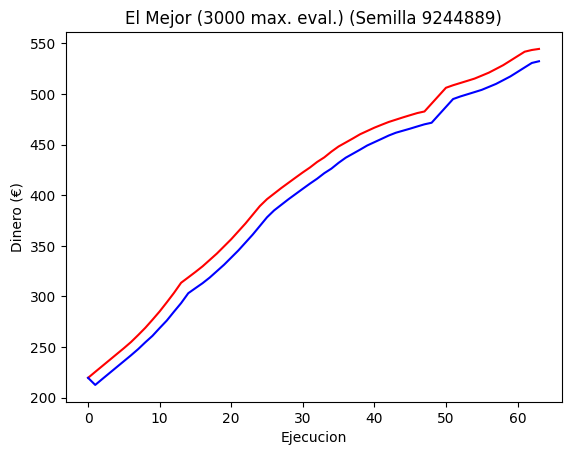

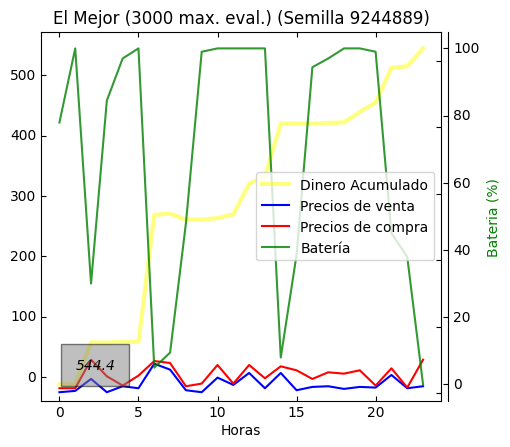

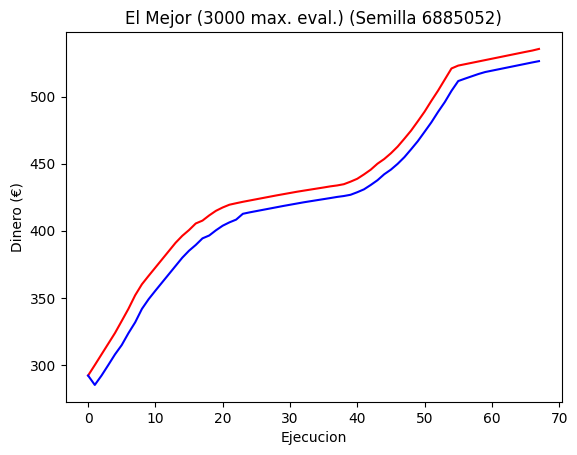

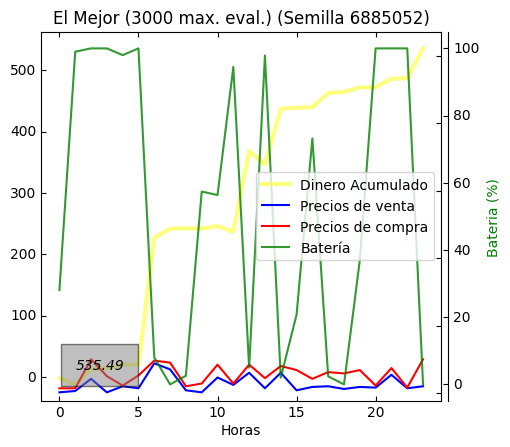

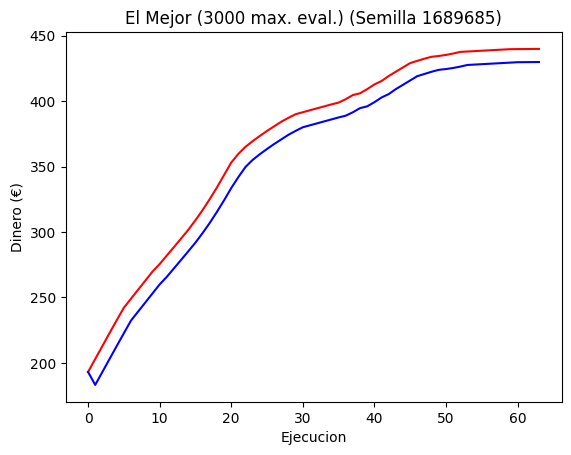

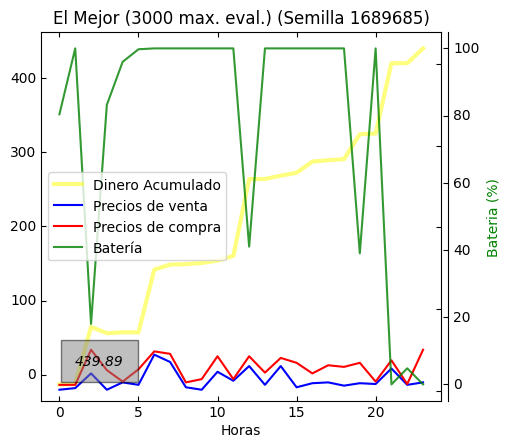

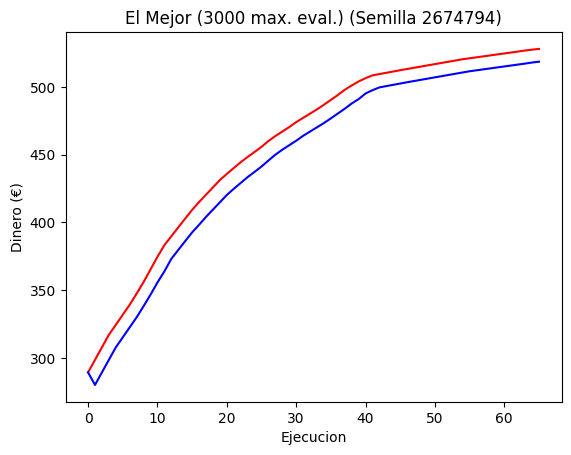

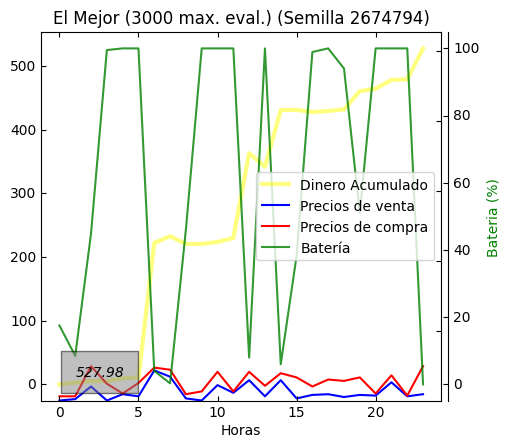

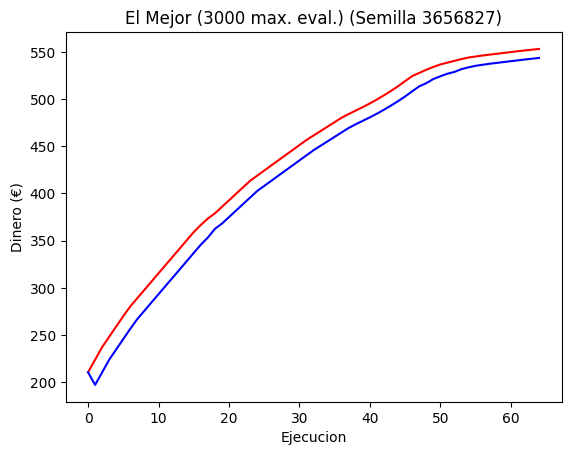

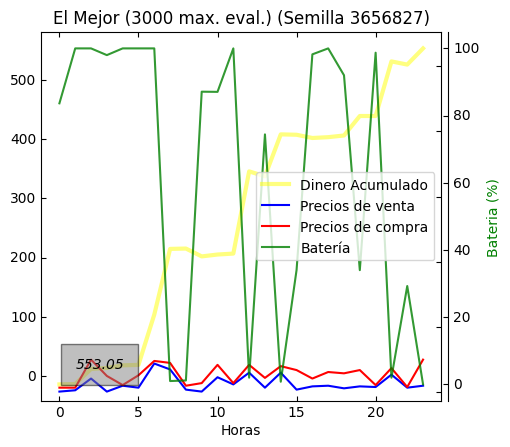

                 El Mejor
Ev. Medias           3036
Ev. Mejor            3025
Ev. Desviación       6.22
Mejor €            553.05
Media €            535.49
Desviación €        45.85
Ev. Mejor Dinero    5: 64
Ev. Medias Mejor       64
Mejor valor: 553.0453912556599
Peor valor: 210.70218923168002


In [58]:
max_evaluaciones=3000
granularidad = 10

parametros = [max_evaluaciones, granularidad]

algorithm_name = mejor_name

Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)
Data.append(mejor_data)

## Algoritmos de Hurísticas No Constructivas

### Funciones Comunes

In [59]:
# Función de inicialización de población
def inicializar_poblacion(n_individuos):
    poblacion = []
    for i in range(n_individuos):
        # Generar un individuo aleatorio
        individuo = solucion_aleatoria()
        poblacion.append(individuo)
    return poblacion

# Función de reemplazo: torneo
def torneo(poblacion, k):
    # Seleccionar k individuos al azar y elegir al mejor
    competidores = random.sample(poblacion, k)
    ganador = max(competidores, key=funcion_evaluacion)
    return ganador

# Operador de cruce: corte en dos puntos
def cruce(individuo1, individuo2):
    # Seleccionar dos puntos aleatorios de corte
    corte1 = random.randint(0, len(individuo1)-1)
    corte2 = random.randint(0, len(individuo1)-1)
    # Asegurar que corte2 > corte1
    if corte2 < corte1:
        corte1, corte2 = corte2, corte1
    # Generar dos hijos combinando las partes de los padres
    hijo1 = individuo1[:corte1] + individuo2[corte1:corte2] + individuo1[corte2:]
    hijo2 = individuo2[:corte1] + individuo1[corte1:corte2] + individuo2[corte2:]
    return hijo1, hijo2

def mutacion(individuo_original, prob_mutacion):
    individuo = individuo_original.copy()
    for i in range(len(individuo)):
        # Seleccionar aleatoriamente si se sumará o restará valor al atributo
        if random.random() < prob_mutacion:
            if random.random() < 0.5:
                # Calcular el rango máximo de variación del atributo
                rango = abs(int(individuo[i] * 0.1))
                # Sumar valor aleatorio dentro del rango máximo
                individuo[i] += random.randint(0, rango)
            else:
                # Calcular el rango máximo de variación del atributo
                rango = abs(int(individuo[i] * 0.1))
                # Restar valor aleatorio dentro del rango máximo
                individuo[i] -= random.randint(0, rango)

        if individuo[i] < -100:
            individuo[i] = -100
        elif individuo[i] > 100:
            individuo[i] = 100
    return individuo

# Función de distancia Hamming
def distancia_hamming(individuo1, individuo2, radio = 5):
    # agregar un umbral, tipo si la dist = 5 -> considerar que es el mismo
    distancia = sum(1 for i in range(len(individuo1)) if (abs(individuo1[i] - individuo2[i]) < radio))
    return distancia

### Algoritmo Genético Básico

Se puede elegir la combinación de operadores y modalidad que crea mas oportuna. Justifique la elección para obtener resultados adecuados según la teoría si es el caso:
- Tipo: Estacionario/Generacional (en dicho caso elite de 5 individuos)
- Mutación de 5% al 20% de los genes son cambiados de media, por cruce o por gen; es decir que se puede realizar mutación en cada cruce con esa probabilidad, o dejar sin mutar algunos cromosomas. La mutación consistirá en una variación del operador de movimiento, en la que se elige aleatoriamente posición y una cantidad a substraer o añadir a esa posición que será aleatoria en un rango no superior a un 10% del total del valor del atributo.
- Población inicial: de 15 a 30 individuos
- Cruce: basado en corte en dos puntos. Se selecciona dos posiciones aleatorias y se generan dos hijos con la combinación de las partes de los padres que determinan estos puntos.
- Cromosoma: Misma representación práctica 1.
- Fitness igual que práctica 1.
- Selección: Torneo (K= % de la población, con un mínimo de 3 individuos), Ruleta Proporcional.
- Reemplazo: (sólo si estacionario), torneo (K= % de la población, con un mínimo de 3 individuos) /Aleatorio/Crowding reemplazando a uno de los padres si lo mejora (sólo si estacionario)
- Criterio de parada: un número de iteraciones determinado por el alumno según la evolución del fitness sin que el mejor individuo haya mejorado su valor.

Los algoritmos genéticos son una técnica de búsqueda y optimización inspirada en la evolución biológica. Se basan en la selección natural, la reproducción y la mutación de los individuos más aptos para obtener soluciones óptimas en problemas complejos. Estos algoritmos utilizan una población de soluciones potenciales que se someten a procesos de selección, cruce y mutación para generar nuevas soluciones.

Los algoritmos genéticos se han utilizado en una amplia variedad de aplicaciones, como la optimización de funciones matemáticas, la programación de horarios, el diseño de circuitos electrónicos y la planificación de rutas de transporte. Estos algoritmos han demostrado ser una herramienta efectiva y eficiente para resolver problemas complejos en diferentes campos. [1]



Se tenía que elegir si programarlo entre:
- **Generacional**: reemplaza completamente la población en cada iteración, es decir, los descendientes reemplazan a los padres. Este proceso puede ser más costoso computacionalmente, pero puede llevar a una convergencia más rápida y a una mayor diversidad de soluciones. [1]
- **Estacionario**: selecciona solo algunos individuos de la población para producir descendientes y reemplazar a algunos de los padres. De esta forma, se mantiene una población estable y se reduce el costo computacional de reemplazar a toda la población en cada iteración. [2]

Debido al posible costo computacional se ha decidido realizar el algoritmo estacionario. No se obtendrá tanta exploración pero sin embargo la explotación será mayor.

Además se ha decidido hacer la selección por torneo y el reemplazo por cruce. Y se ha añadido un parámetro extra por si los tiempos de computo eran muy altos, un número máximo de iteraciones sin mejora.


[1]: *Goldberg, D. E. (1989). Genetic Algorithms in Search, Optimization and Machine Learning. Addison-Wesley*
[2]: *Back, T., Fogel, D. B., & Michalewicz, Z. (2000). Evolutionary computation 1: Basic algorithms and operators. Institute of Physics Publishing.*

In [60]:
# Algoritmo genético
def algoritmo_genetico_basico(n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, prob_mutacion = 0.2):
    # Inicializar parámetros de medición de rendimiento
    totales_soluciones = []
    totales_soluciones_peores = []
    contador_evaluaciones = 0
    # Inicializar población
    poblacion = inicializar_poblacion(n_individuos)
    # Evaluar la población inicial
    evaluaciones = [funcion_evaluacion(individuo) for individuo in poblacion]
    contador_evaluaciones += len(poblacion)

    # Encontrar el mejor individuo de la población inicial
    valor_mejor_individuo = max(evaluaciones)
    mejor_individuo = poblacion[evaluaciones.index(valor_mejor_individuo)]
    contador_evaluaciones += 1
    totales_soluciones.append(valor_mejor_individuo)

    # Encontrar el peor individuo de la población inicial
    valor_peor_individuo = min(evaluaciones)
    totales_soluciones_peores.append(valor_peor_individuo)

    # Inicializar contador de iteraciones sin mejora
    iter_sin_mejora = 0
    # Bucle principal del algoritmo
    for i in range(max_iteraciones):
        # Seleccionar dos padres y asegurar que k es minimo 3
        k = int(porcentaje_torneo * len(poblacion))
        if k<3:
            k = 3
        padre1 = torneo(poblacion, k)
        padre2 = torneo(poblacion, k)
        # Aplicar operador de cruce para obtener dos hijos
        hijo1, hijo2 = cruce(padre1, padre2)

        # Aplicar mutación a los hijos
        hijo1 = mutacion(hijo1, prob_mutacion)
        hijo2 = mutacion(hijo2, prob_mutacion)

        # Evaluar los hijos
        valor_hijo1 = funcion_evaluacion(hijo1)
        contador_evaluaciones += 1
        valor_hijo2 = funcion_evaluacion(hijo2)
        contador_evaluaciones += 1
        # Seleccionar el peor de los padres
        peor_padre = min(poblacion, key=funcion_evaluacion)
        valor_peor_padre = funcion_evaluacion(peor_padre)
        contador_evaluaciones += 1
        # Reemplazar el peor padre por el mejor hijo si lo mejora
        if valor_hijo1 > valor_hijo2:
            mejor_hijo = hijo1
            valor_mejor_hijo = valor_hijo1
            valor_peor_hijo = valor_hijo2
        else:
            mejor_hijo = hijo2
            valor_mejor_hijo = valor_hijo2
            valor_peor_hijo = valor_hijo1

        if valor_mejor_hijo > valor_peor_padre:
            poblacion[poblacion.index(peor_padre)] = mejor_hijo
            # Actualizar mejor individuo
            if valor_mejor_hijo > valor_mejor_individuo:
                mejor_individuo = mejor_hijo
                valor_mejor_individuo = valor_mejor_hijo
                iter_sin_mejora = 0
            else:
                iter_sin_mejora += 1
        else:
            iter_sin_mejora += 1

        valor_peor_individuo = funcion_evaluacion(min(poblacion, key=funcion_evaluacion))

        # Criterio de parada: si no hay mejora en el mejor individuo durante un número determinado de iteraciones
        if iter_sin_mejora >= max_iteraciones_sin_mejora:
            break

        totales_soluciones.append(valor_mejor_individuo)
        totales_soluciones_peores.append(valor_peor_individuo)

    return mejor_individuo, contador_evaluaciones, totales_soluciones, totales_soluciones_peores


#### Genético Básico Base
Podemos observar que con 1000 iteraciones en las gráficas de evaluación no se consigue mucha mejora a partir del 25%, sigue mejorando pero no mucho, además, la desviación de evaluaciones es de 300 que es un 25% del número de iteraciones máximas por lo que la variable extra introducida de max_iteraciones_sin_mejora actúa en el algoritmo y limita el número de iteraciones que se realiza.

El valor de la mejor solución es 330.78 y la peor 298, la mejora no es muy grande y la desviación tampoco lo es.

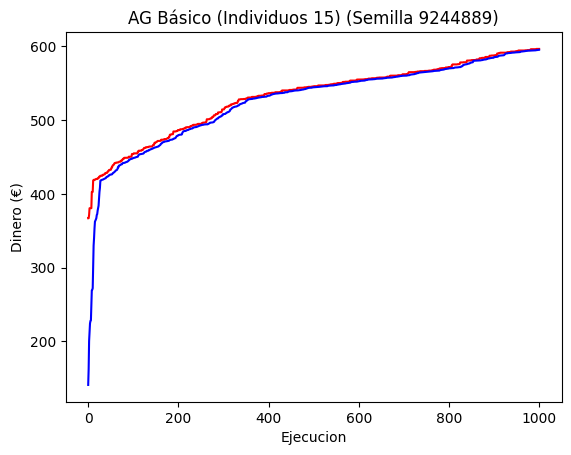

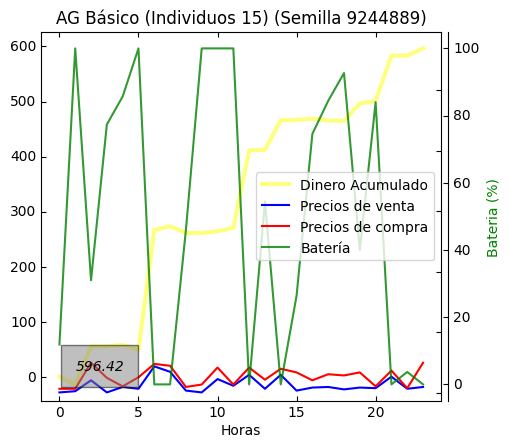

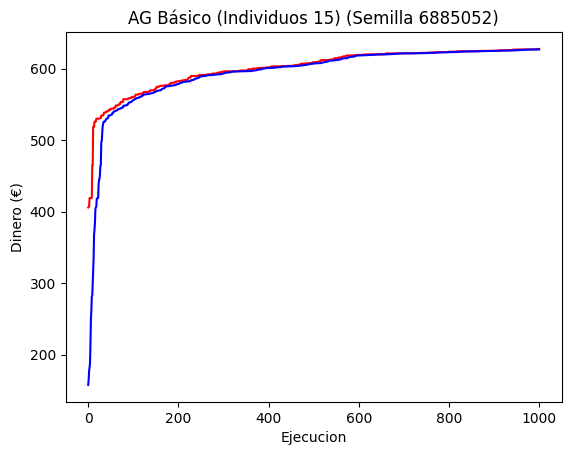

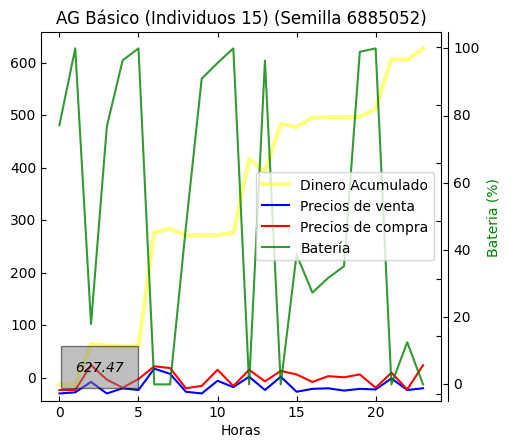

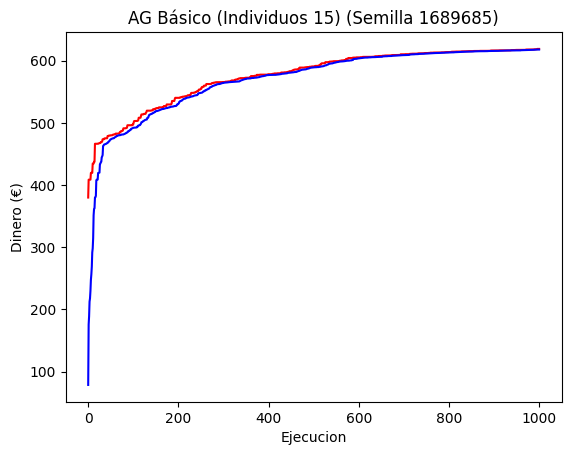

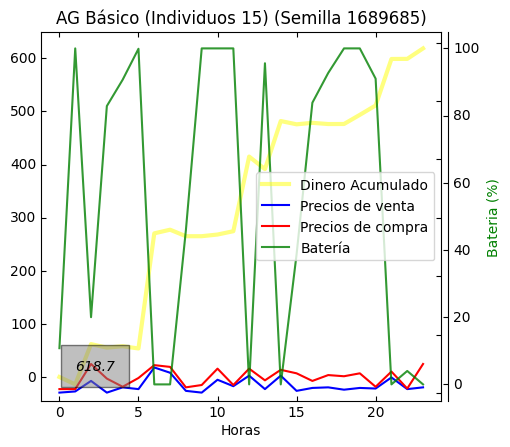

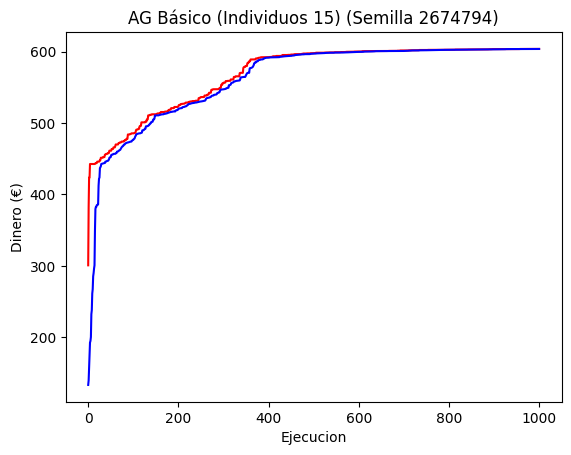

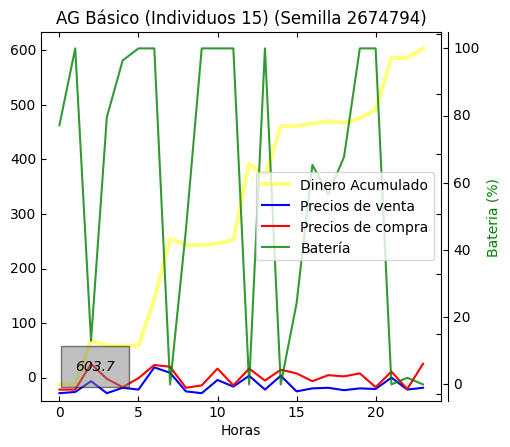

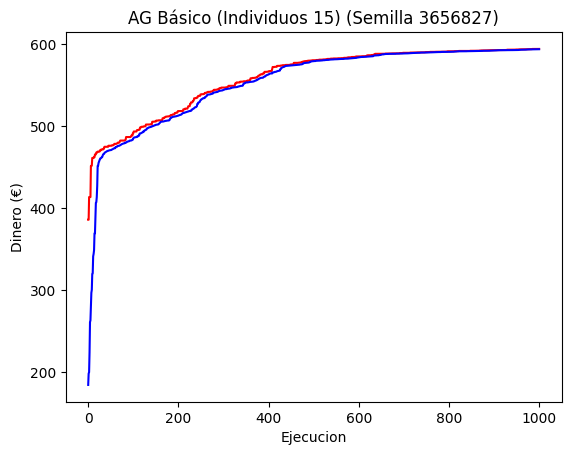

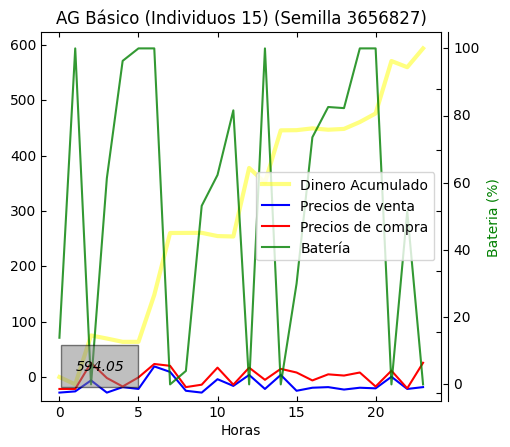

                 AG Básico
Ev. Medias            3016
Ev. Mejor             3016
Ev. Desviación         0.0
Mejor €             627.47
Media €              603.7
Desviación €          14.5
Ev. Mejor Dinero    2: 997
Ev. Medias Mejor       994
Mejor valor: 594.0545943366399
Peor valor: 385.94501840000004


In [61]:
n_individuos= 15
max_iteraciones = 1000
max_iteraciones_sin_mejora = 100
porcentaje_torneo = 0.2
prob_mutacion = 0.15

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, prob_mutacion]

algorithm_name = algoritmo_genetico_basico_name

# Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

# Data.append(mejor_data)

#### Genético Básico - Más individuos, sin límites de iteraciones sin mejora

Esta vez al incrementar el número de individuos es de esperar que la exploración sea mayor y al aumentar también el número máximo de iteraciones se esperan mejores resultados aunque tendrá mayor coste computacional.

La mejora conseguida en la mejor solución ha sido mínima, de 330 hemos pasado a 332, lo que hace plantearse si realmente merece la pena el coste computacional para una mejora tan pequeña. Podría ser también por el porcentaje de torneo, que ha permanecido constante.

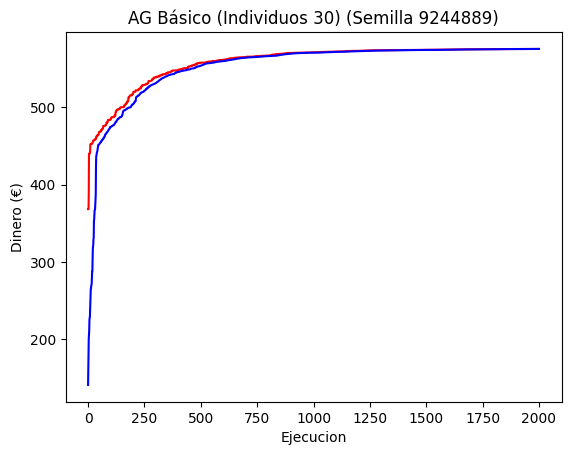

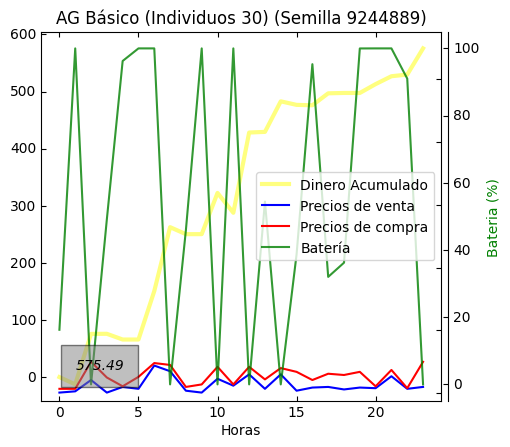

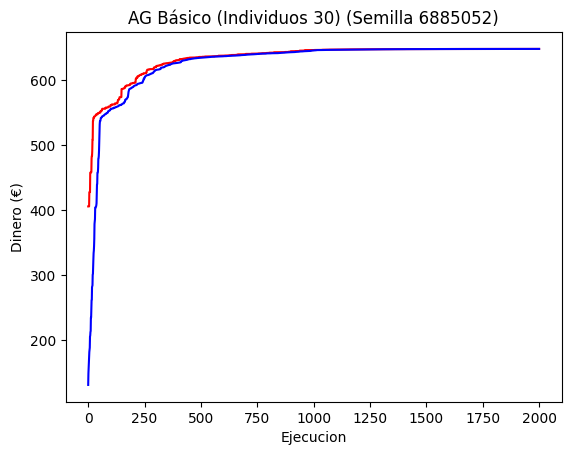

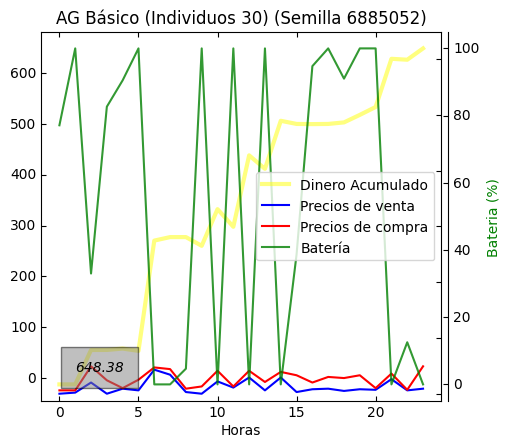

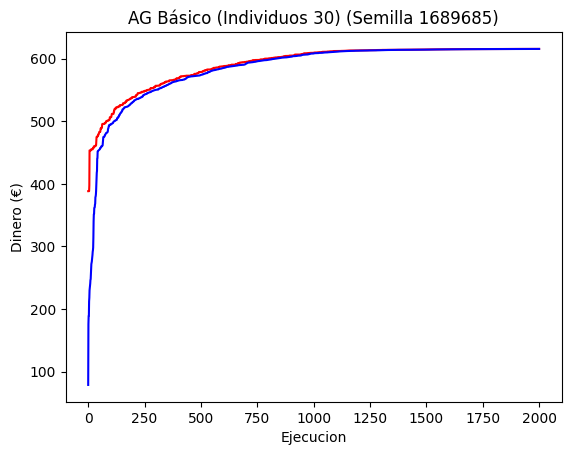

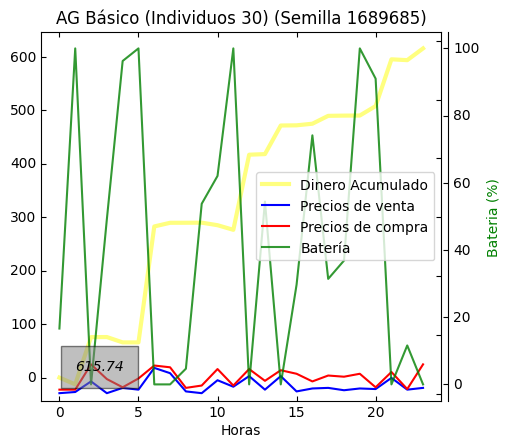

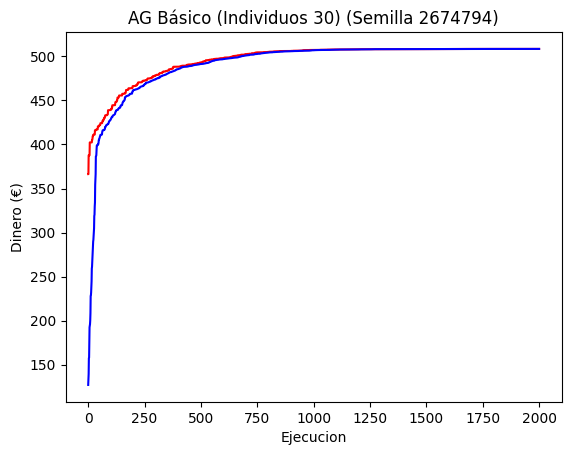

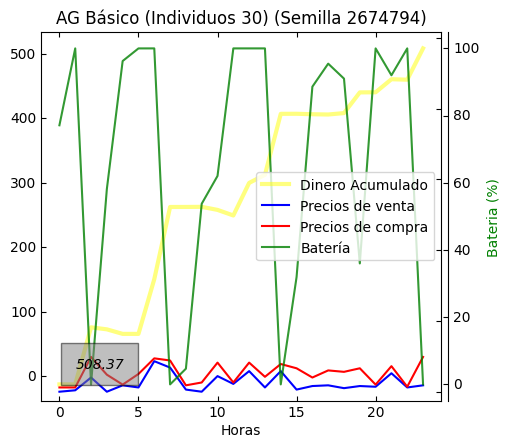

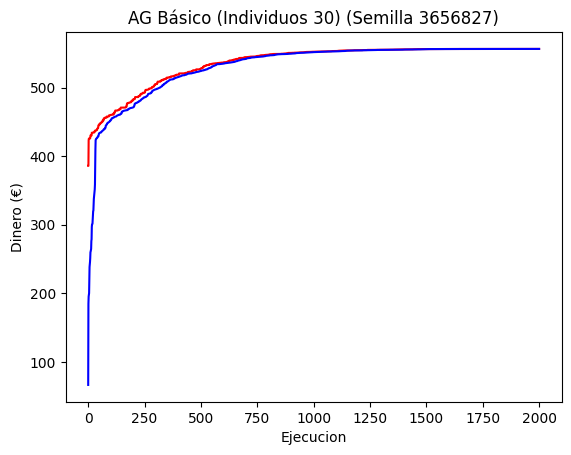

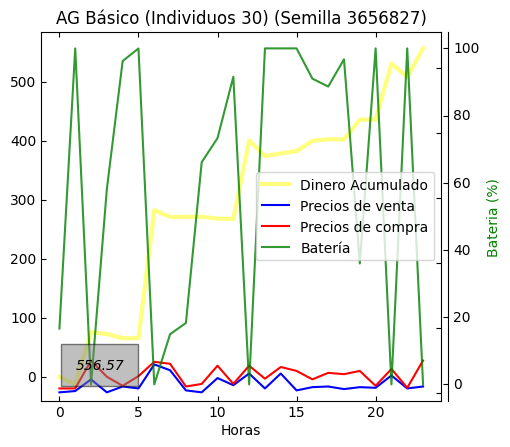

                 AG Básico
Ev. Medias            6031
Ev. Mejor             6031
Ev. Desviación         0.0
Mejor €             648.38
Media €             575.49
Desviación €         53.96
Ev. Mejor Dinero   2: 1724
Ev. Medias Mejor      1965
Mejor valor: 556.5705426975936
Peor valor: 385.94501840000004


In [62]:
n_individuos= 30
max_iteraciones = 2000
max_iteraciones_sin_mejora = float("inf")
porcentaje_torneo = 0.2
prob_mutacion = 0.15

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, prob_mutacion]

algorithm_name = algoritmo_genetico_basico_name

# Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

# Data.append(mejor_data)

Se ha probado incrementando el porcentaje de torneo, sin embargo, no se ha conseguido ninguna mejora, por lo que el porcentaje de torneo se dejará en 0.2

#### Genético Básico Optimizado

Al no conseguir mejoras incrementando el porcentaje de torneo se ha reducido y así se ha conseguido una pequeña mejora. El número máximo de iteraciones se deja en 2000 ya que si se incrementa se consigue mayor robustez pero sin embargo, la curva de evolución que se puede observar deja de crecer muy pronto, sobre la iteración 2000.

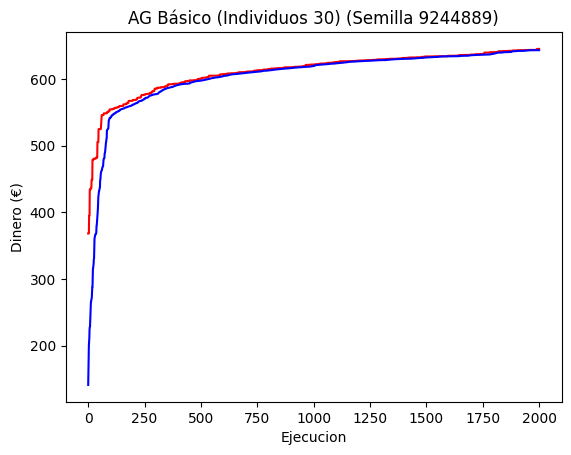

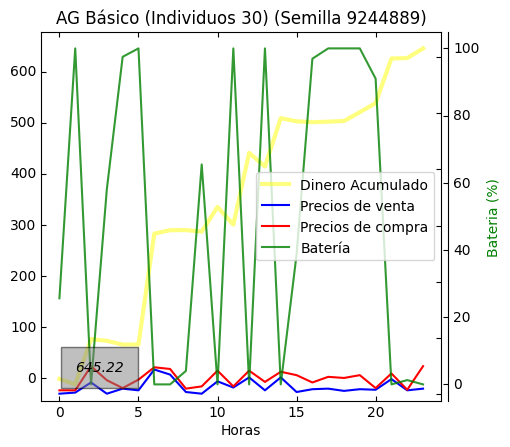

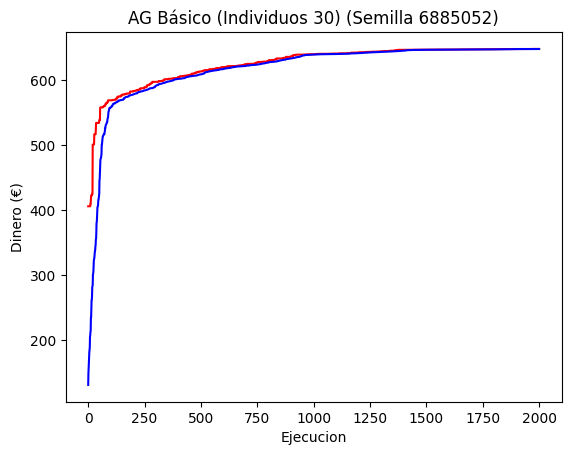

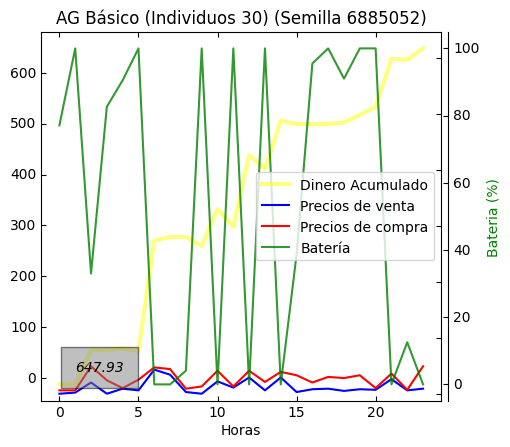

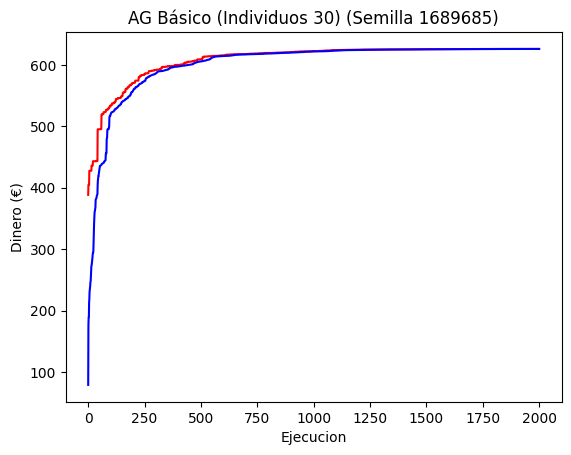

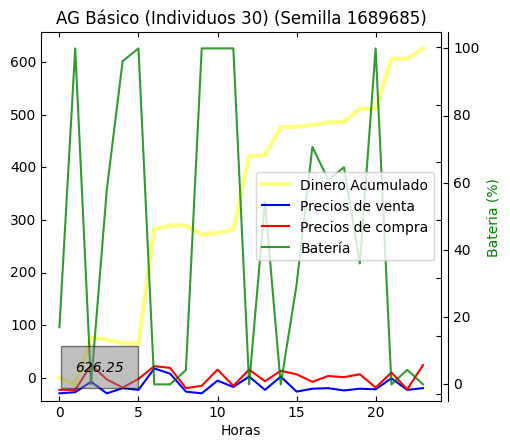

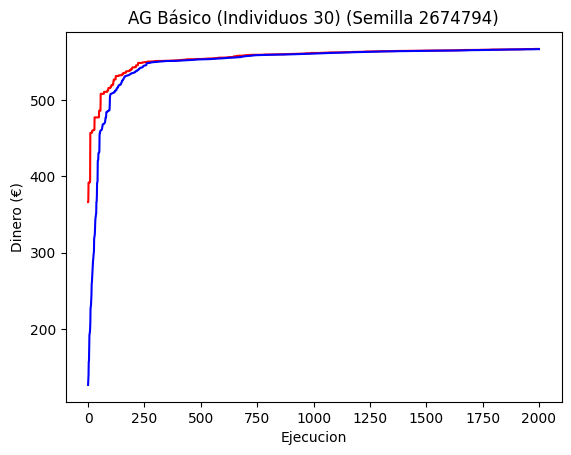

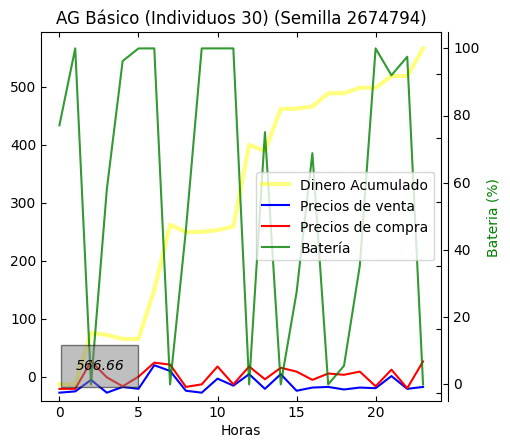

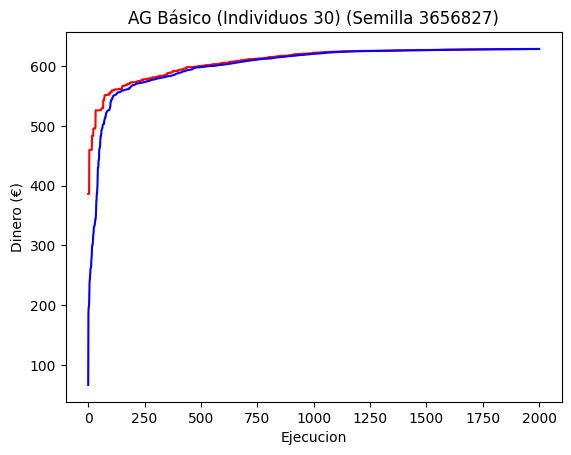

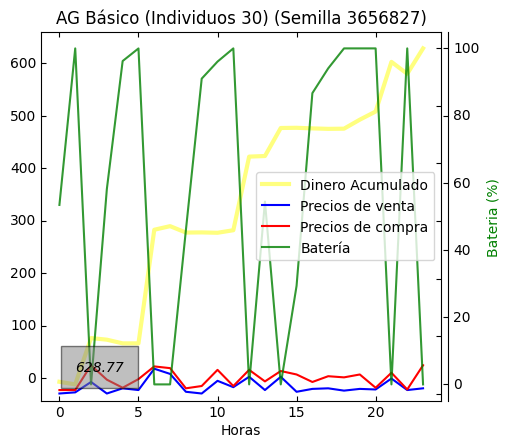

                 AG Básico
Ev. Medias            6031
Ev. Mejor             6031
Ev. Desviación         0.0
Mejor €             647.93
Media €             628.77
Desviación €         32.92
Ev. Mejor Dinero   2: 1970
Ev. Medias Mejor      1979
Mejor valor: 628.7704969999999
Peor valor: 385.94501840000004


In [63]:
n_individuos= 30
max_iteraciones = 2000
max_iteraciones_sin_mejora = float("inf")
porcentaje_torneo = 0.1
prob_mutacion = 0.15

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, prob_mutacion]

algorithm_name = algoritmo_genetico_basico_name

Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(mejor_data)

### Algoritmo Genético CHC

Aunque el algoritmo CHC fue concebido para cromosomas con codificación binaria, existen versiones para su uso con cromosomas con codificación en vector. El cálculo de la distancia de Hamming se realizará teniendo en cuenta cuantos genes difieren entre sí (cuantas posiciones difieren). Sólo aquellas cadenas con una distancia (mayor del umbral) serán combinados. El umbral se inicializará a L/4 siendo L la longitud de la cadena o cromosoma.

Cuando ningún descendiente es insertado en la nueva población el umbral se reduce a 1. En la fase de recombinación no se aplica ningún proceso de mutación. En su lugar, cuando la población converge o el proceso de búsqueda deja de progresar adecuadamente (el umbral de cruce llega a 0 y no se generan nuevos descendientes), la población se reiniciará. El cromosoma que represente la mejor solución hasta ese momento se utilizará como patrón para generar la nueva población (copiándose), y el resto se inicializarán de forma aleatoria.

La población debe ser menor o igual a la elegida en el genético básico. En el arranque, los valores de un cromosoma corresponden al mejor individuo de la generación anterior, y el resto serán aleatorios.

Se pueden poner más copias del mejor individuo para acelerar el proceso de reinicio si este es muy lento tras la primera reinicialización.

Hay que utilizar uno de los siguientes cruces:
- Parent Centered
- BLX-Alfa

Los cruces en CHC se hacen cambiando exactamente la mitad de los elementos QUE SON DISTINTOS en ambos padres y luego aplicando Parent Centered (una mutación similar a la mutación del genético básico) o BLX-Alpha (que genera un valor para cada hijo aplicando el algoritmo descrito en los apuntes).

Deberá reiniciar a menos cuatro veces. Criterio de parada: un número de iteraciones determinado por el alumno según la evolución del fitness sin que el mejor individuo haya mejorado su valor.

Los algoritmos genéticos CHC (Crowding, Homogeneous, and Crossover) son una técnica de búsqueda y optimización que se enfoca en mantener una alta diversidad en la población. Utilizan un enfoque de "cruce homogéneo" que evita la creación de soluciones no viables durante el proceso de recombinación. Además, utilizan un mecanismo de "crowding" para reemplazar soluciones similares por soluciones más diversas.

Los algoritmos genéticos CHC han demostrado ser efectivos en la resolución de problemas de optimización en diferentes áreas, como la programación de horarios y la selección de características. La combinación de la alta diversidad en la población y el enfoque de cruces homogéneos y crowding permite encontrar soluciones óptimas en problemas complejos. [1]

Se podía realizar uno de los siguientes cruces:
- **Parent Centered**: técnica de recombinación en la que se selecciona un subconjunto de los padres de la población y se generan descendientes a partir de ellos. En este proceso, los padres son seleccionados en función de su aptitud y se produce una mezcla de sus características para generar nuevos individuos. [2]
- **BLX-Alfa**: técnica de cruce que genera nuevos individuos dentro de una región del espacio de búsqueda definida por dos soluciones padre. Este operador produce hijos que son una combinación lineal de los padres y su variabilidad depende de un parámetro alfa que controla el grado de exploración del espacio de búsqueda. [1]

El cruce parent-centered puede ser preferible cuando se busca una mayor exploración del espacio de búsqueda y una mayor diversidad en la población de soluciones. Además, puede ser efectivo en problemas en los que se requiere una adaptación rápida a cambios en el entorno.

Por otro lado, el operador BLX-alfa puede ser preferible en problemas en los que se desea una mayor explotación de las soluciones existentes. Además, puede ser efectivo en problemas con poblaciones de soluciones altamente correlacionadas.

Es decir, BLX-Alfa, podría ser mejor para este problema ya que las soluciones están altamente correlacionadas, pero para intentar encontrar una mayor exploración se implementará el parent-centered.

[1]: *Eshelman, L. J., & Schaffer, J. D. (1993). Real-coded genetic algorithms and interval-schemata. Foundations of genetic algorithms, 187-202.*
[2]: *Harik, G. R., Lobo, F. G., & Goldberg, D. E. (1999). The compact genetic algorithm. IEEE Transactions on Evolutionary Computation, 3(4), 287-297.*

In [64]:
# Función de selección
def seleccion_chc(poblacion, tamano_nuevo, distancia_maxima):
    nueva_poblacion = []
    while len(nueva_poblacion) < tamano_nuevo:
        # Seleccionar dos individuos aleatorios de la población
        padre1 = random.choice(poblacion)
        padre2 = random.choice(poblacion)
        # Realizar cruce parent-centered para generar un hijo
        hijo = []
        for i in range(len(padre1)):
            if padre1[i] == padre2[i]:
                hijo.append(padre1[i])
            else:
                if random.random() < 0.5:
                    hijo.append(padre1[i])
                else:
                    hijo.append(padre2[i])
        # Generar un individuo aleatorio que tenga una distancia máxima con el hijo generado
        individuo_nuevo = copy.deepcopy(hijo)
        while distancia_hamming(individuo_nuevo, hijo) < distancia_maxima:
            for i in range(len(hijo)):
                if random.random() < 0.5:
                    individuo_nuevo[i] = hijo[i]
                else:
                    individuo_nuevo[i] = 1 - hijo[i]
        # Añadir el nuevo individuo a la nueva población
        nueva_poblacion.append(individuo_nuevo)
    return nueva_poblacion

# Algoritmo genético CHC
def algoritmo_genetico_chc(n_individuos, max_iteraciones, tamano_nuevo, distancia_maxima = 12, umbral_reinicializaciones = 5):
    # Inicializar parámetros de medición de rendimiento
    totales_soluciones = []
    totales_soluciones_peores = []
    contador_evaluaciones = 0
    num_reinicializaciones = 0

    # Inicializar población
    poblacion = inicializar_poblacion(n_individuos)

    # Evaluar la población inicial
    evaluaciones = [funcion_evaluacion(individuo) for individuo in poblacion]
    contador_evaluaciones += len(poblacion)

    # Encontrar el mejor individuo de la población inicial
    valor_mejor_individuo = max(evaluaciones)
    mejor_individuo = poblacion[evaluaciones.index(valor_mejor_individuo)]
    contador_evaluaciones += 1
    totales_soluciones.append(valor_mejor_individuo)

    # Peor individuo
    valor_peor_individuo = min(evaluaciones)
    totales_soluciones_peores.append(valor_peor_individuo)

    # Bucle principal del algoritmo
    # for i in range(max_iteraciones):
    n_iteraciones = 0
    while num_reinicializaciones <= umbral_reinicializaciones or n_iteraciones < max_iteraciones:

        valor_peor_individuo = min(evaluaciones)

        # Seleccionar una nueva población
        poblacion_nueva = seleccion_chc(poblacion, tamano_nuevo, distancia_maxima)

        # Evaluar la población
        evaluaciones_nueva = [funcion_evaluacion(individuo) for individuo in poblacion_nueva]
        contador_evaluaciones += len(poblacion_nueva)

        # Encontrar el mejor individuo de la nueva población
        valor_mejor_individuo_iter = max(evaluaciones_nueva)
        mejor_individuo_iter = poblacion_nueva[evaluaciones_nueva.index(valor_mejor_individuo_iter)]
        contador_evaluaciones += 1

        # valor_peor_individuo = min(evaluaciones_nueva)

        # Actualizar el mejor individuo global si corresponde
        if valor_mejor_individuo_iter > valor_mejor_individuo:
            valor_mejor_individuo = valor_mejor_individuo_iter
            mejor_individuo = mejor_individuo_iter

        # Si no se insertó ningún individuo nuevo en la nueva población
        # se realiza una reinicialización y se cuenta
        if np.array_equal(poblacion, poblacion_nueva):
            # print("Reinicio")
            num_reinicializaciones += 1
            poblacion = inicializar_poblacion(n_individuos)
            evaluaciones = [funcion_evaluacion(individuo) for individuo in poblacion]
            valor_peor_individuo = min(evaluaciones)
        else:
            poblacion = poblacion_nueva
            evaluaciones = evaluaciones_nueva

        # Si se alcanza el umbral de reinicializaciones, se sale del bucle principal -> no parar hasta que no haga minimo 4 reinicializacionses
        '''if num_reinicializaciones >= umbral_reinicializaciones:
            break'''

        totales_soluciones.append(valor_mejor_individuo)
        totales_soluciones_peores.append(valor_peor_individuo)

        n_iteraciones += 1

    print("Ha reiniciado " + str(num_reinicializaciones) + " veces")


    return mejor_individuo, contador_evaluaciones, totales_soluciones, totales_soluciones_peores


#### Genético CHC Base

Ha reiniciado 15 veces


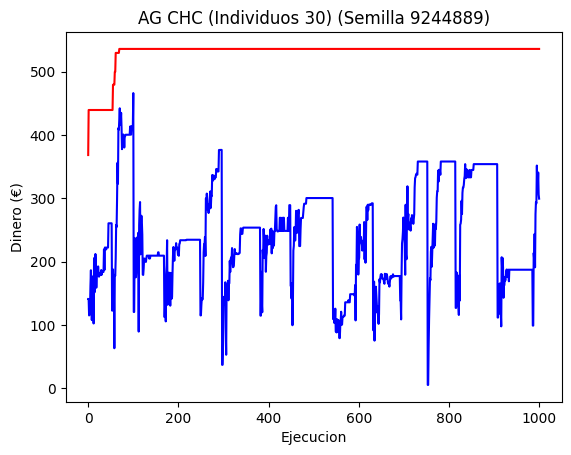

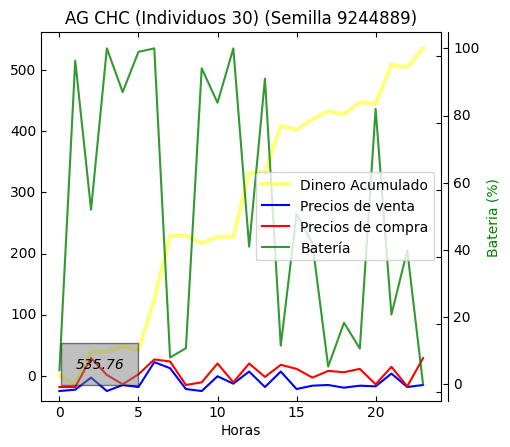

Ha reiniciado 14 veces


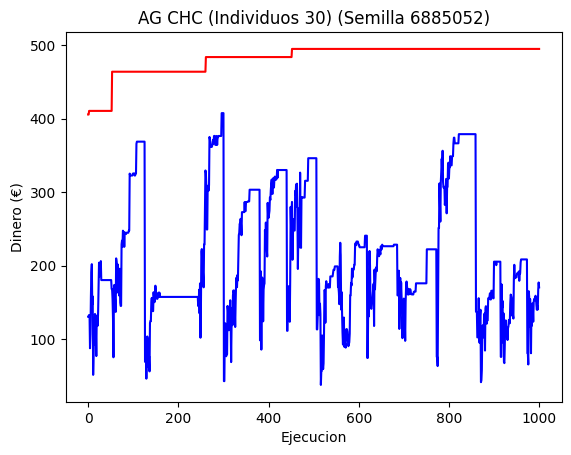

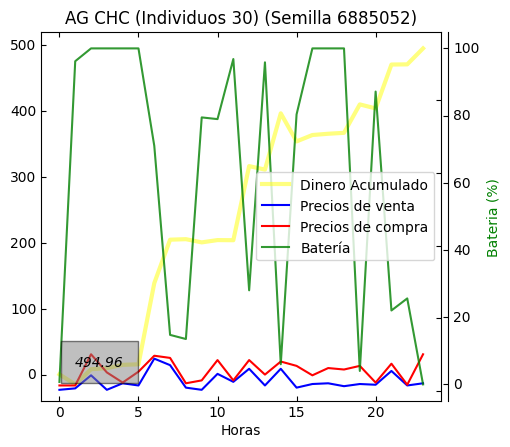

Ha reiniciado 12 veces


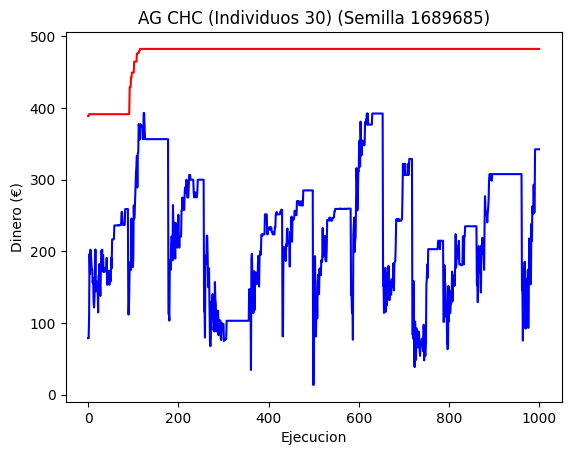

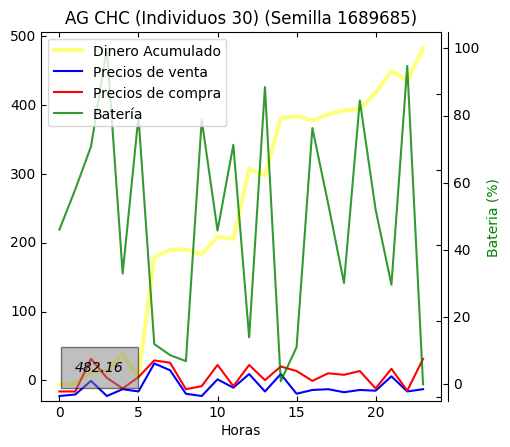

Ha reiniciado 14 veces


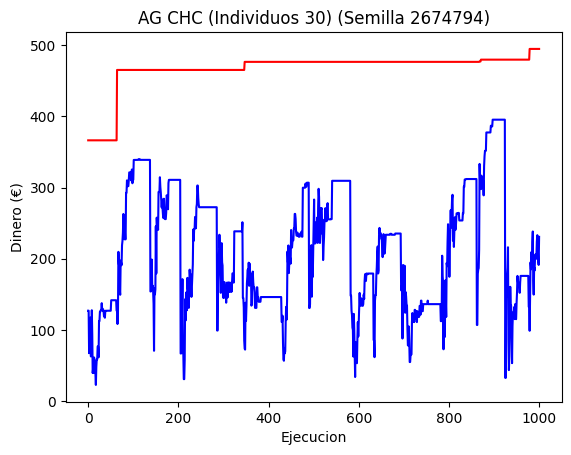

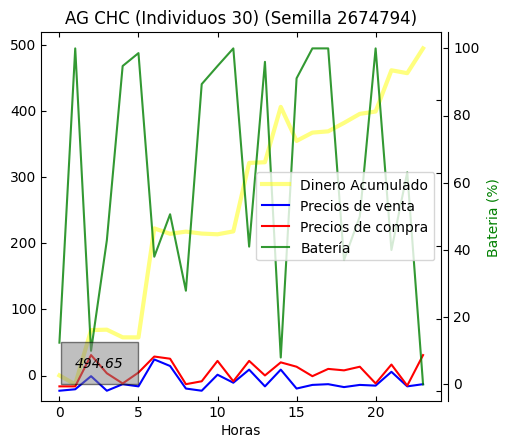

Ha reiniciado 14 veces


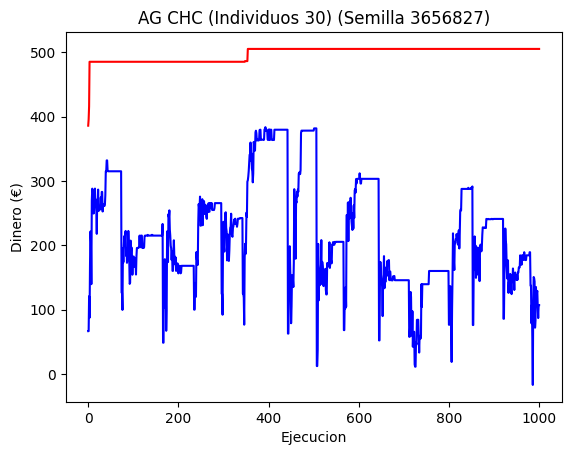

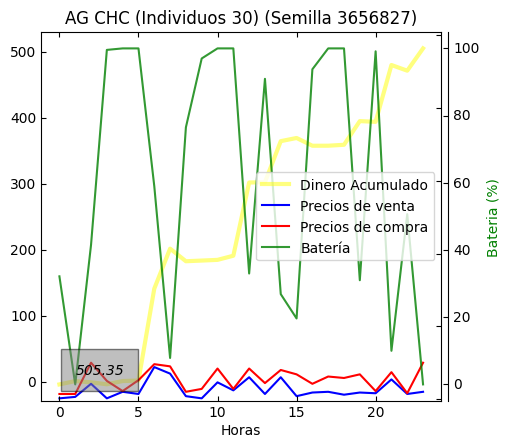

                  AG CHC
Ev. Medias         16031
Ev. Mejor          16031
Ev. Desviación       0.0
Mejor €           535.76
Media €           494.96
Desviación €       20.29
Ev. Mejor Dinero   1: 69
Ev. Medias Mejor     354
Mejor valor: 505.347733744
Peor valor: 385.94501840000004


In [65]:
n_individuos= 30
max_iteraciones = 1000
tamano_nuevo = int(n_individuos/2)
distancia_maxima = len(horas)/4 # dist maxima será como muchisimo el num de elementos del esq de representacon (24), empieza en este caso en 6
umbral_reinicios = 4

parametros = [n_individuos, max_iteraciones, tamano_nuevo, distancia_maxima, umbral_reinicios]

algorithm_name = algoritmo_genetico_CHC_name

# Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

# Data.append(mejor_data)

#### Genético CHC - Más individuos, más iteraciones

Se esperaría mejorar al haber más individuos por lo que hay una mayor exploración, los resultados son los esperados.

Ha reiniciado 27 veces


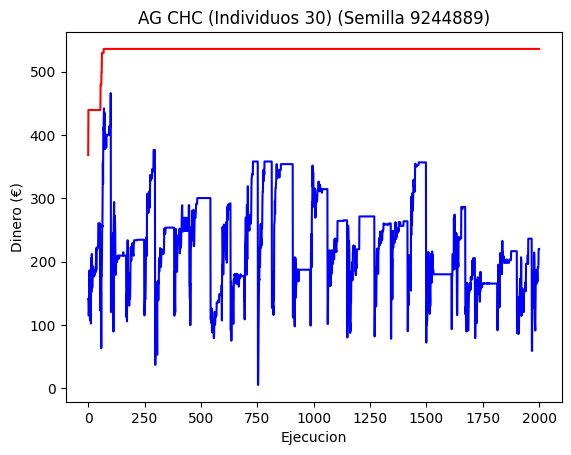

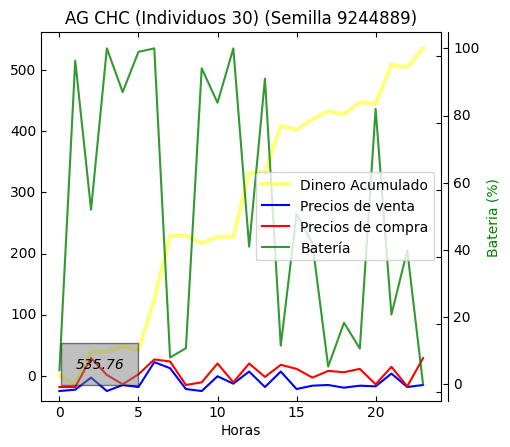

Ha reiniciado 27 veces


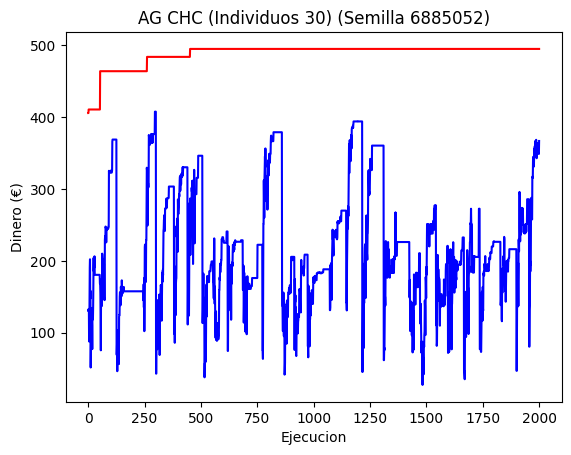

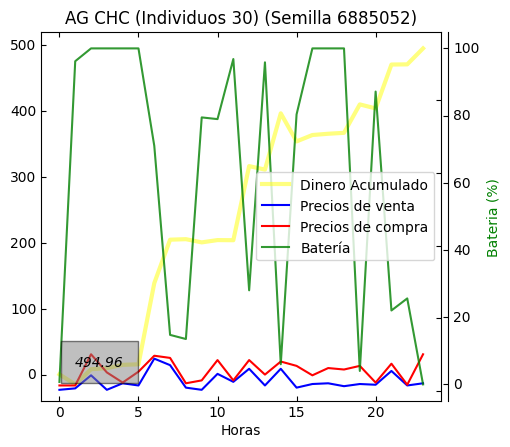

Ha reiniciado 26 veces


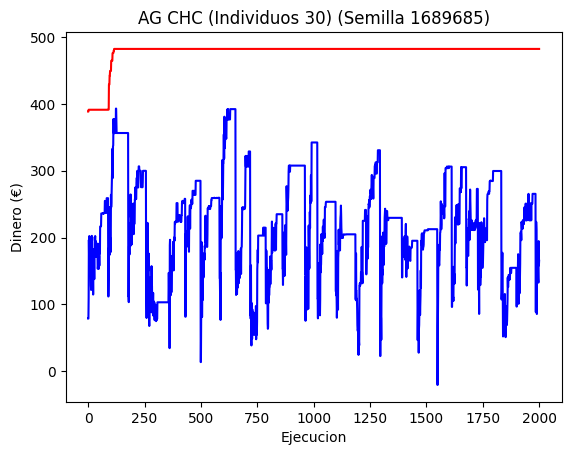

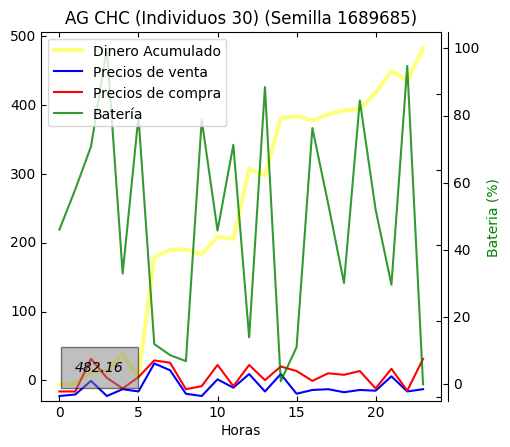

Ha reiniciado 27 veces


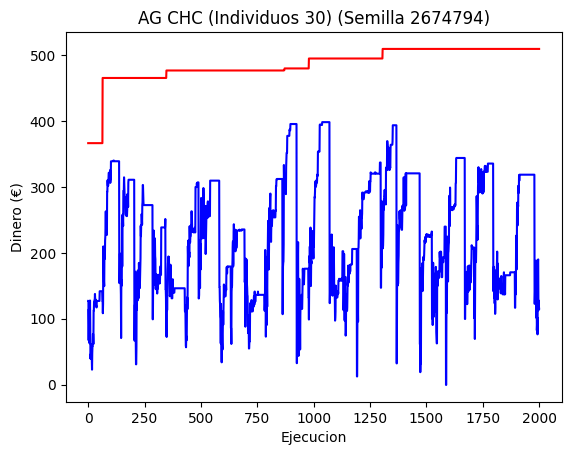

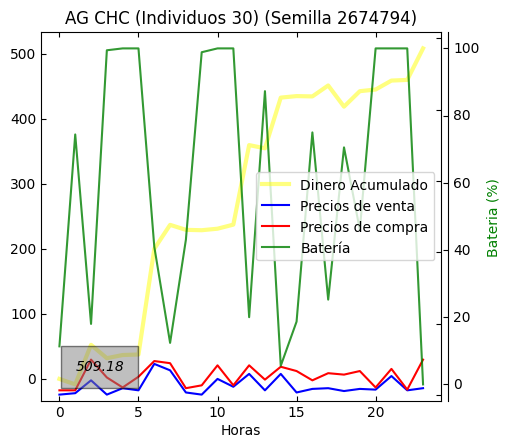

Ha reiniciado 28 veces


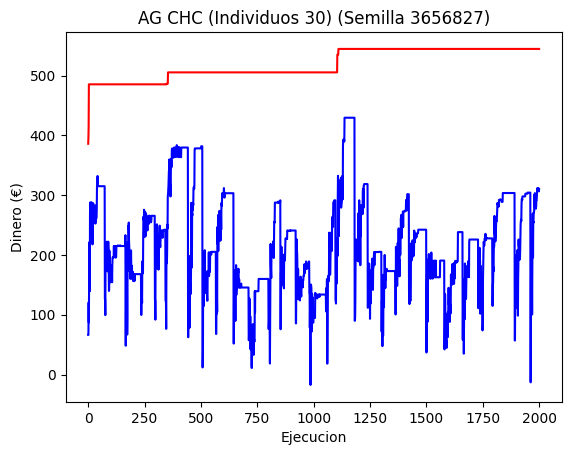

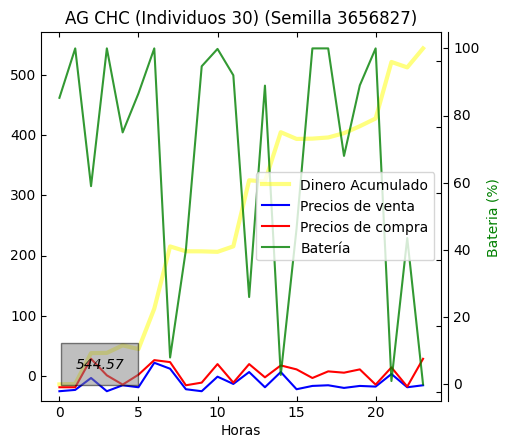

                   AG CHC
Ev. Medias          32031
Ev. Mejor           32031
Ev. Desviación        0.0
Mejor €            544.57
Media €            509.18
Desviación €        26.48
Ev. Mejor Dinero  5: 1110
Ev. Medias Mejor      452
Mejor valor: 544.56599058
Peor valor: 385.94501840000004


In [66]:
n_individuos= 30
max_iteraciones = 2000
tamano_nuevo = int(n_individuos/2)
distancia_maxima = len(horas)/4
umbral_reinicios = 4

parametros = [n_individuos, max_iteraciones, tamano_nuevo, distancia_maxima, umbral_reinicios]

algorithm_name = algoritmo_genetico_CHC_name

# Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

# Data.append(mejor_data)

#### Genético CHC Optimizado

Ha reiniciado 65 veces


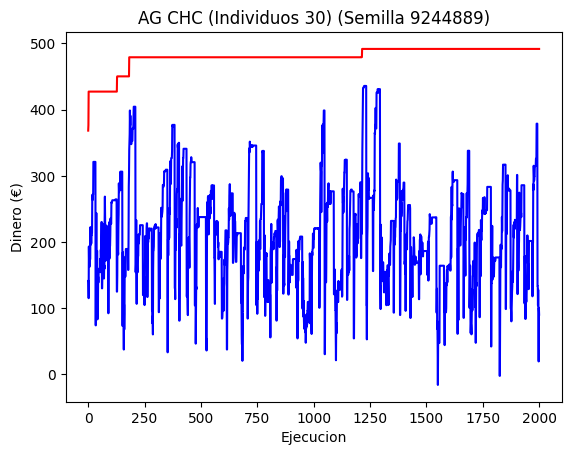

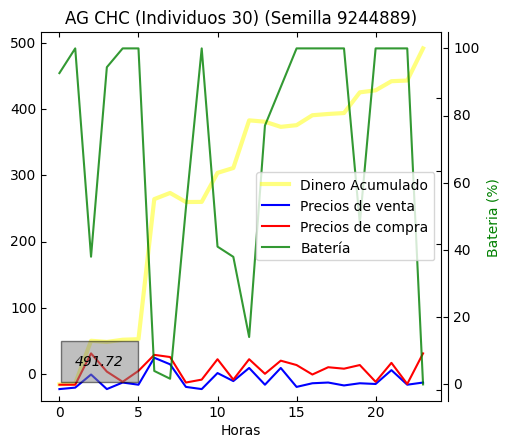

Ha reiniciado 63 veces


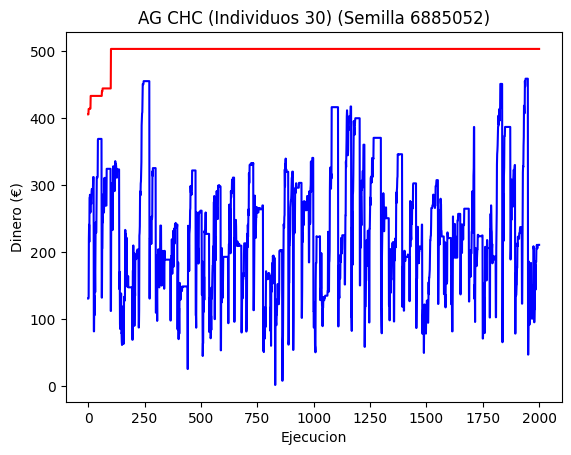

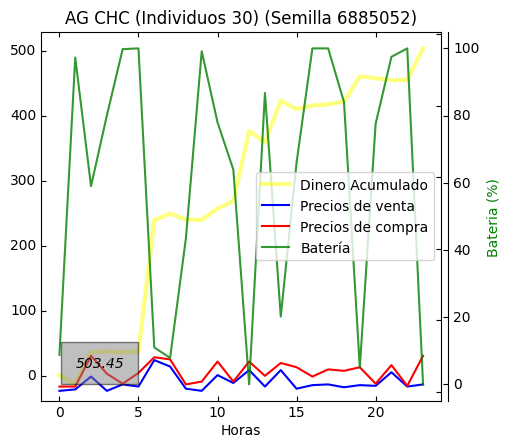

Ha reiniciado 62 veces


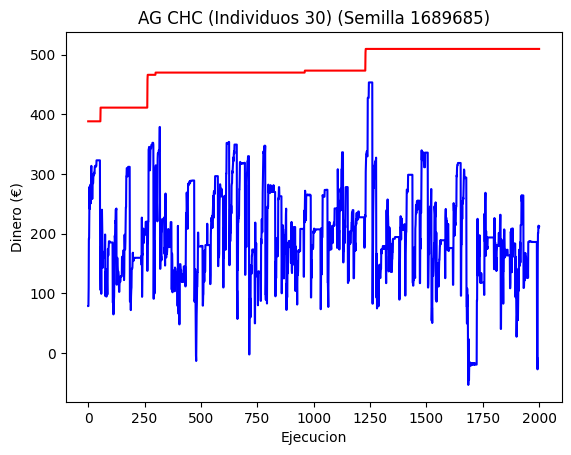

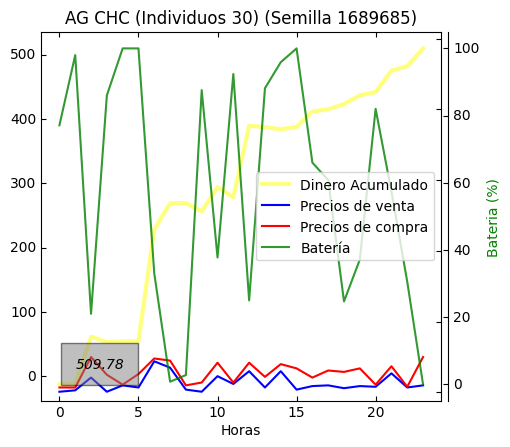

Ha reiniciado 64 veces


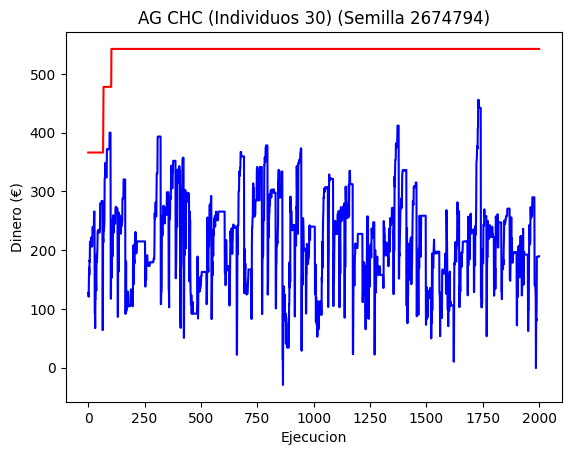

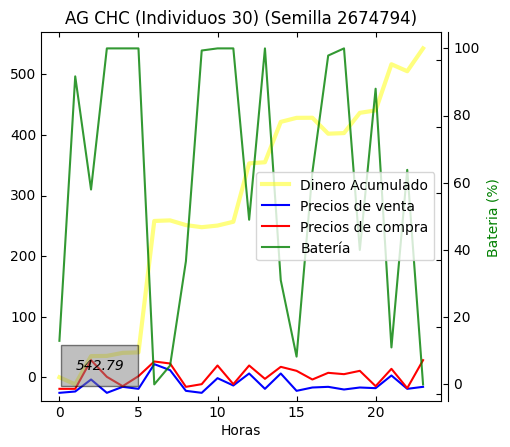

Ha reiniciado 63 veces


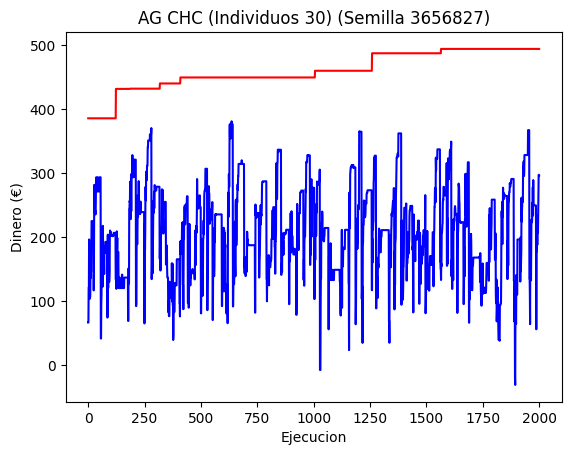

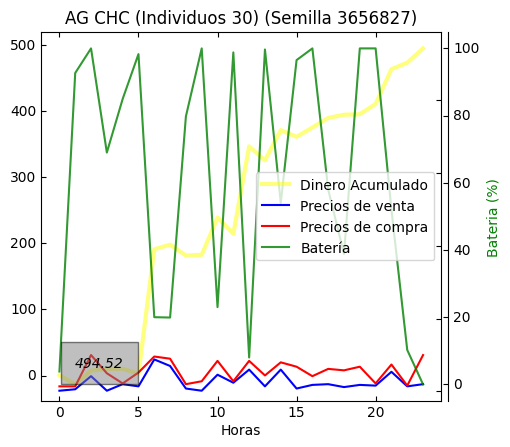

                  AG CHC
Ev. Medias         16031
Ev. Mejor          16031
Ev. Desviación       0.0
Mejor €           542.79
Media €           503.45
Desviación €       20.49
Ev. Mejor Dinero  4: 103
Ev. Medias Mejor    1215
Mejor valor: 494.5243839999998
Peor valor: 385.94501840000004


In [67]:
n_individuos= 30
max_iteraciones = 2000
tamano_nuevo = int(n_individuos/4)
distancia_maxima = len(horas)/2
umbral_reinicios = 6

parametros = [n_individuos, max_iteraciones, tamano_nuevo, distancia_maxima, umbral_reinicios]

algorithm_name = algoritmo_genetico_CHC_name

Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(mejor_data)

### Algoritmo Genético Multimodal

Considerando como partida el AG Básico, debe implementar un AG multimodal espacial mediante el método de secuencial (5 nichos) o clearing, determinando un radio adecuado basado en la distancia de hamming.

- Donde d(i,j) es la distancia entre las soluciones.(distancia Hamming)
- Tamaño de la población menor o igual al genético básico.
- Probabilidad de cruce 0.8. (si no se cruza se copia como hijo )
- Mantener misma mutación que en el algoritmo básico.

El valor del radio tanto para el secuencial como para el clearing es crítico y debe ser propuesto por el alumno para que las soluciones finales sean suficientemente diferentes. Un radio muy pequeño no afectará casi nunca a los individuos al realizar el clearing o adaptar el fitness en el conjunto de soluciones y un valor muy alto hará que todos estén penalizados

En clearing es conveniente dejar un número de generaciones entre operaciones de aclarado, este parámetro denominado P, en el el generacional P iteraciones y en el estacionario p*Población/2 ya que una población equivalente se genera cada ese número de cruces. La kappa (numero de representantes de un nicho tiene que ser >= 2, para evitar que en un clearing quede sólo un elemento si los demás están en el mismo nicho y así poder generar el resto de los individuos hasta  rellenar la población cruzando los que hayan quedado del aclarado.

Los algoritmos genéticos multimodales son una variante de los algoritmos genéticos que se utilizan para optimizar funciones con múltiples óptimos locales. En estos algoritmos, se busca mantener una diversidad alta en la población para evitar la convergencia temprana a una solución óptima local y explorar diferentes regiones del espacio de búsqueda.

Para lograr esto, se utilizan técnicas como el niching, que consiste en identificar y mantener soluciones que pertenecen a diferentes nichos o regiones del espacio de búsqueda. Además, se pueden utilizar operadores de mutación y cruce que fomenten la exploración de nuevas regiones del espacio de búsqueda. [1]

- **Secuencial**: técnica de optimización que se utiliza para encontrar múltiples óptimos locales de una función objetivo. En este enfoque, se utilizan técnicas de niching y operadores genéticos que fomentan la diversidad de la población de soluciones. El algoritmo secuencial busca un óptimo local a la vez y utiliza el resultado para generar una nueva población de soluciones que se enfoca en encontrar el siguiente óptimo local.
- **Clearing**: técnica de optimización que se enfoca en mantener la diversidad de la población de soluciones y eliminar soluciones redundantes. En este enfoque, se asigna un nivel de fitness a cada solución en función de su distancia a otras soluciones de la población. Las soluciones con un nivel de fitness inferior se eliminan de la población para mantener una alta diversidad. [3]

[1]: *Deb, K., Thiele, L., Laumanns, M., & Zitzler, E. (2002). Scalable multi-objective optimization test problems. IEEE Transactions on Evolutionary Computation, 8(3), 223-246.*
[2]: *Hornby, G. S., & Pollack, J. B. (2001). Body-brain co-evolution using L-systems as a generative encoding. Proceedings of the Genetic and Evolutionary Computation Conference, 239-246.*
[3]: *Spears, W. M. (1994). Adaptive clearing for two-dimensional function optimization. Complex Systems, 8(1), 1-24.*


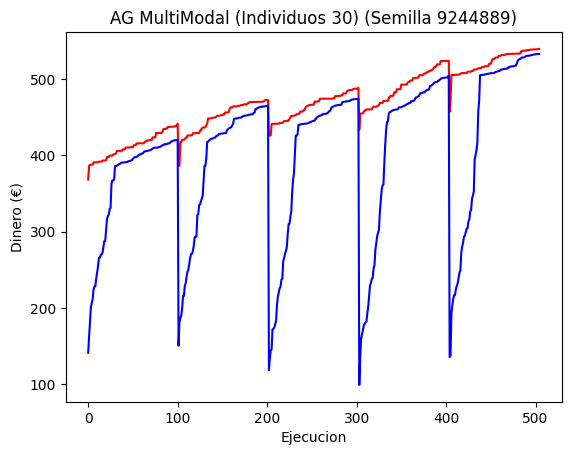

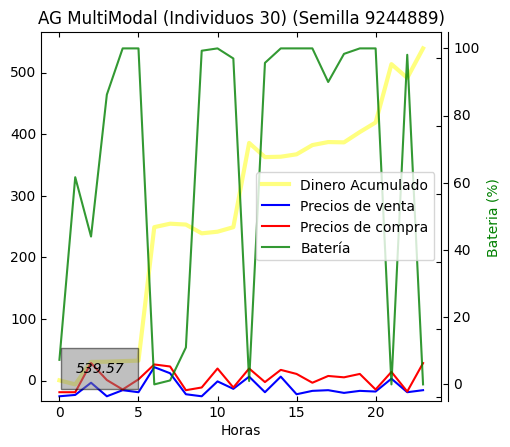

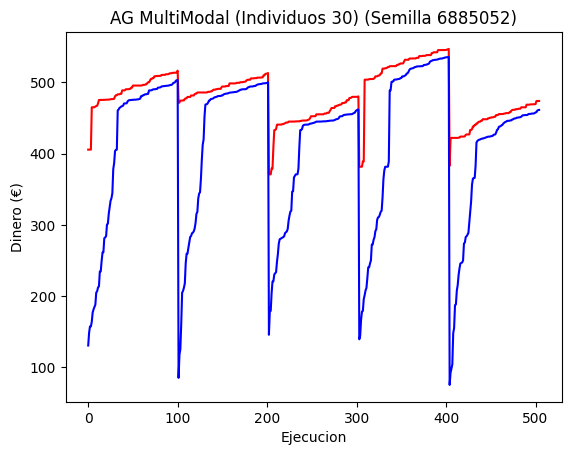

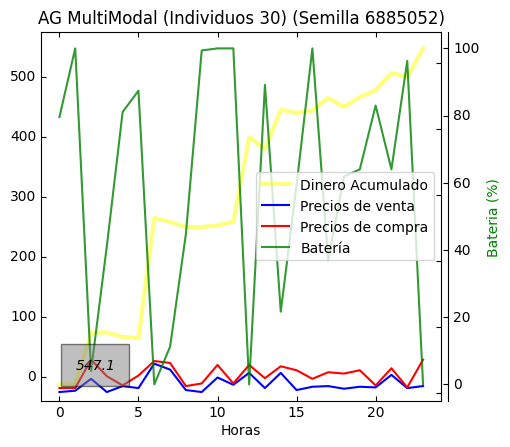

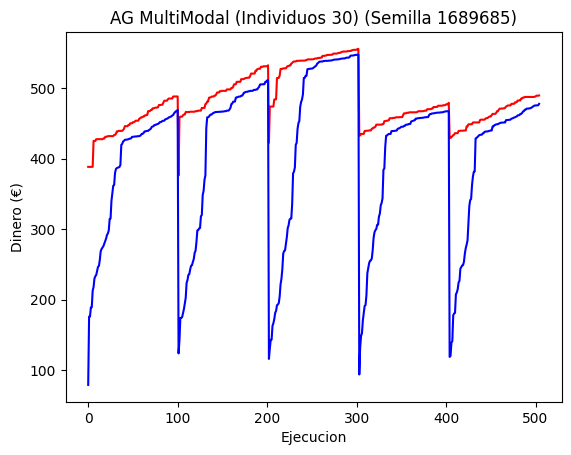

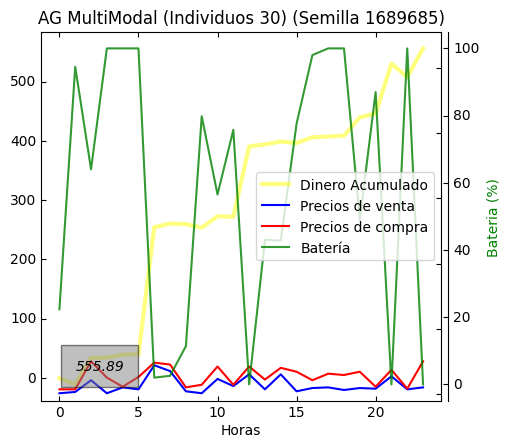

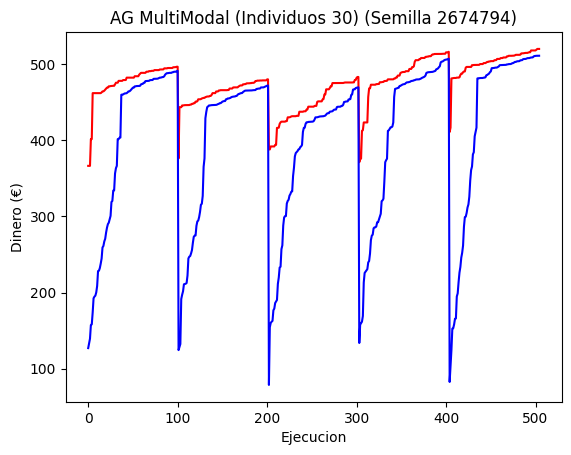

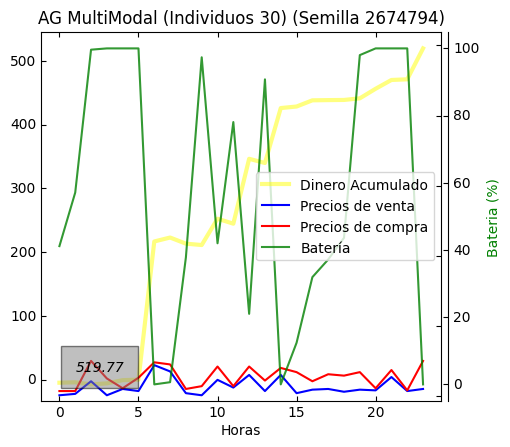

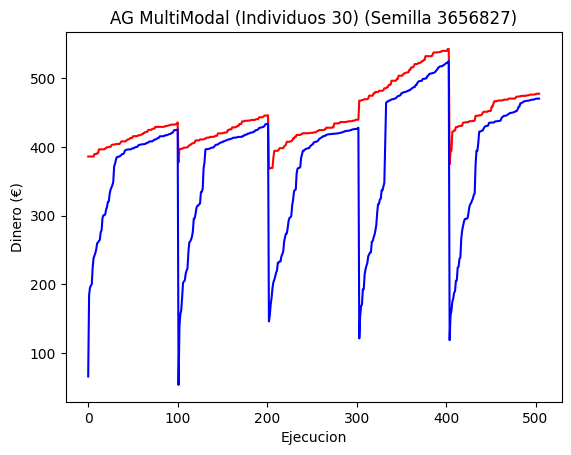

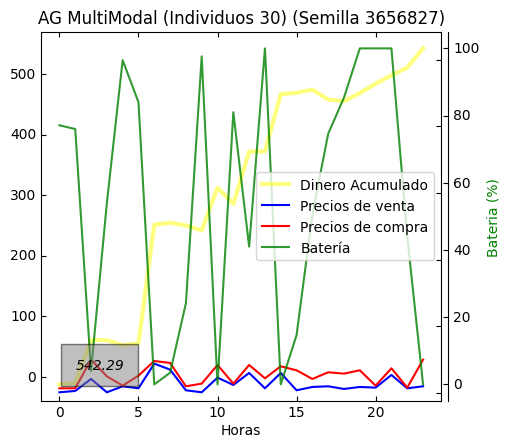

                 AG MultiModal
Ev. Medias                1655
Ev. Mejor                 1655
Ev. Desviación             0.0
Mejor €                 555.89
Media €                 542.29
Desviación €             13.35
Ev. Mejor Dinero        3: 301
Ev. Medias Mejor           403
Mejor valor: 542.2890157879999
Peor valor: 368.3270610513279


In [68]:
# Algoritmo genético :

def penalizar(conjunto_soluciones, solucion, radio):
    valor = funcion_evaluacion(solucion)
    G_x = 1
    for solucion_conjunto in conjunto_soluciones:
        distancia = distancia_hamming(solucion_conjunto, solucion, radio)
        if distancia < radio:
            G_x *= distancia / radio

    return valor * G_x

def algoritmo_genetico_multimodal(n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, prob_mutacion = 0.2, n_nichos = 5, radio = 5):
    # Inicializar parámetros de medición de rendimiento
    totales_soluciones = []
    totales_soluciones_peores = []
    contador_evaluaciones = 0
    valor_mejor_individuo= float("-inf")

    for i in range(n_nichos):
        # Bucle principal del algoritmo
        # Inicializar contador de iteraciones sin mejora
        iter_sin_mejora = 0
        conjunto_soluciones = []

        # Inicializar población
        poblacion = inicializar_poblacion(n_individuos)
        # Evaluar la población inicial
        evaluaciones = [funcion_evaluacion(individuo) for individuo in poblacion]
        contador_evaluaciones += len(poblacion)

        # Encontrar el mejor individuo de la población inicial
        valor_mejor_individuo_nicho = max(evaluaciones)
        mejor_individuo_nicho = poblacion[evaluaciones.index(valor_mejor_individuo_nicho)]
        contador_evaluaciones += 1
        totales_soluciones.append(valor_mejor_individuo_nicho)

        # Encontrar el peor individuo de la población inicial
        valor_peor_individuo = min(evaluaciones)
        totales_soluciones_peores.append(valor_peor_individuo)

        for i in range(max_iteraciones):

            # Seleccionar dos padres y asegurar que k es minimo 3
            k = int(porcentaje_torneo * len(poblacion))
            if k<3:
                k = 3
            padre1 = torneo(poblacion, k)
            padre2 = torneo(poblacion, k)
            # Aplicar operador de cruce para obtener dos hijos
            hijo1, hijo2 = cruce(padre1, padre2)

            # Aplicar mutación a los hijos
            hijo1 = mutacion(hijo1, prob_mutacion)
            hijo2 = mutacion(hijo2, prob_mutacion)

            # Evaluar los hijos
            valor_hijo1 = penalizar(conjunto_soluciones, hijo1, radio) # nichos secuenciales iii -> formula if hamming entonces aplicar else 1

            contador_evaluaciones += 1
            valor_hijo2 = penalizar(conjunto_soluciones, hijo2, radio) # valor hijo 2 = penalizar(conjunto_sol, valor_hijo1)
            contador_evaluaciones += 1
            # Seleccionar el peor de los padres
            peor_padre = min(poblacion, key=funcion_evaluacion)
            valor_peor_padre = funcion_evaluacion(peor_padre)
            contador_evaluaciones += 1
            # Reemplazar el peor padre por el mejor hijo si lo mejora
            if valor_hijo1 > valor_hijo2:
                mejor_hijo = hijo1
                valor_mejor_hijo = valor_hijo1
            else:
                mejor_hijo = hijo2
                valor_mejor_hijo = valor_hijo2

            if valor_mejor_hijo > valor_peor_padre:
                poblacion[poblacion.index(peor_padre)] = mejor_hijo
                # Actualizar mejor individuo
                if valor_mejor_hijo > valor_mejor_individuo_nicho:
                    mejor_individuo_nicho = mejor_hijo
                    valor_mejor_individuo_nicho = valor_mejor_hijo
                    iter_sin_mejora = 0

                if valor_mejor_hijo > valor_mejor_individuo:
                    mejor_individuo = mejor_hijo
                    valor_mejor_individuo = valor_mejor_hijo
                    iter_sin_mejora = 0
                else:
                    iter_sin_mejora += 1
            else:
                iter_sin_mejora += 1

            valor_peor_individuo = funcion_evaluacion(min(poblacion, key=funcion_evaluacion))

            # Criterio de parada: si no hay mejora en el mejor individuo durante un número determinado de iteraciones
            if iter_sin_mejora >= max_iteraciones_sin_mejora:
                break


            conjunto_soluciones.append(mejor_individuo_nicho)

            if len(conjunto_soluciones)>4:
                conjunto_soluciones = conjunto_soluciones[4:]

            totales_soluciones.append(valor_mejor_individuo_nicho)
            totales_soluciones_peores.append(valor_peor_individuo)

    return mejor_individuo, contador_evaluaciones, totales_soluciones, totales_soluciones_peores



n_individuos= 30
max_iteraciones = 100
max_iteraciones_sin_mejora = 100
porcentaje_torneo = 0.4
prob_mutacion = 0.2
n_nicho = 5
radio = 10

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, n_nicho, prob_mutacion, radio]

algorithm_name = algoritmo_genetico_multimodal_name

# Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

# Data.append(mejor_data)

#### Genético Multimodal Base

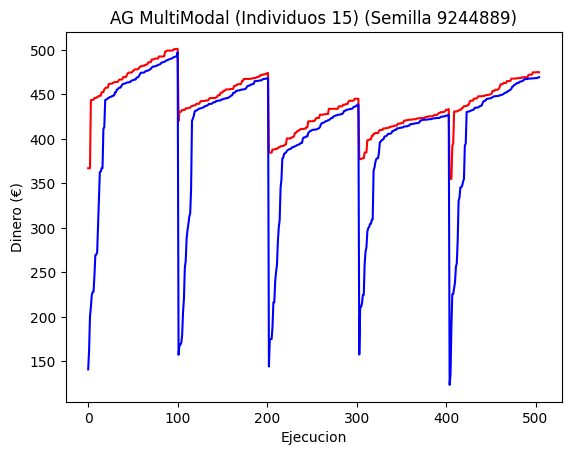

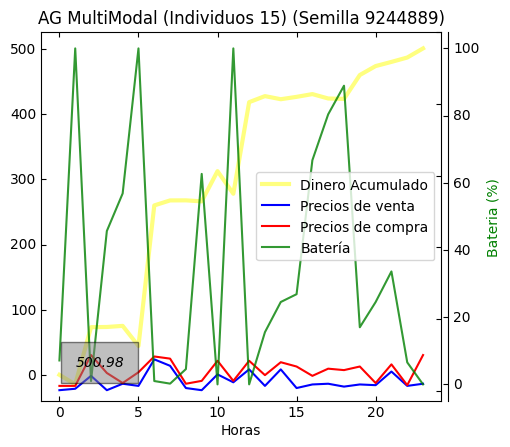

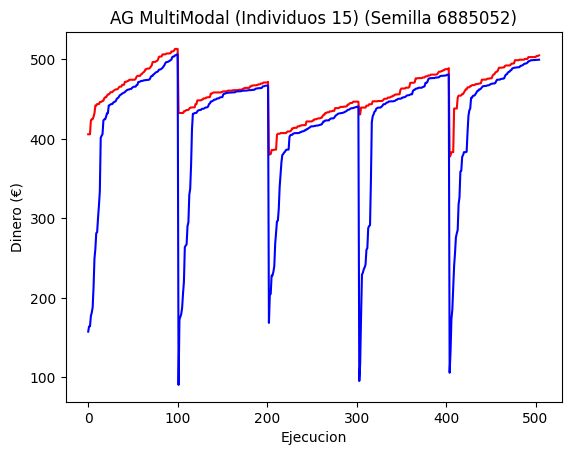

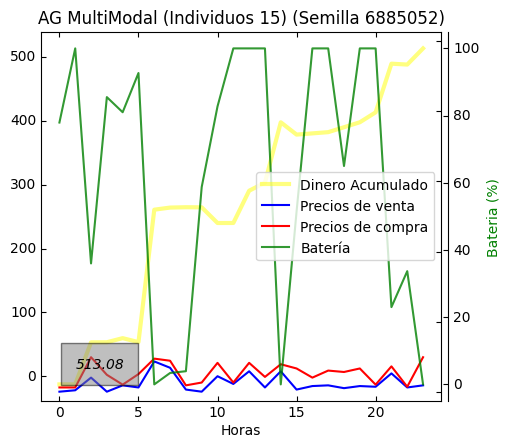

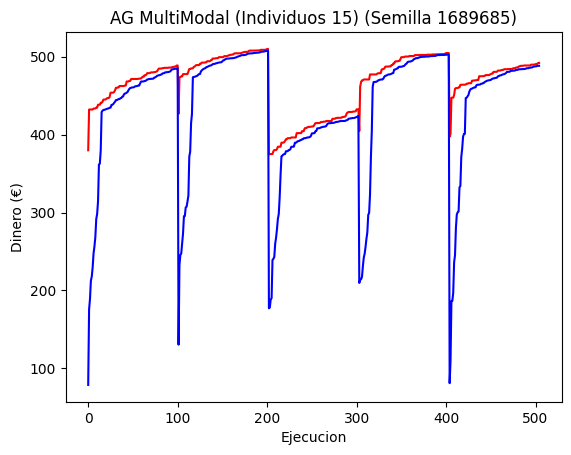

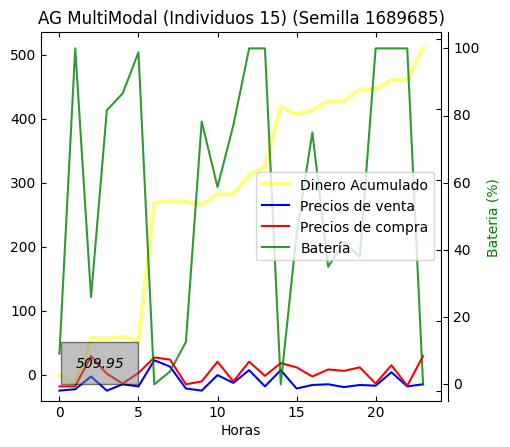

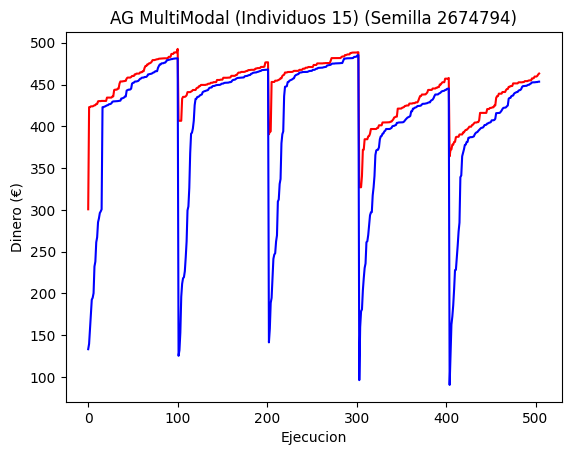

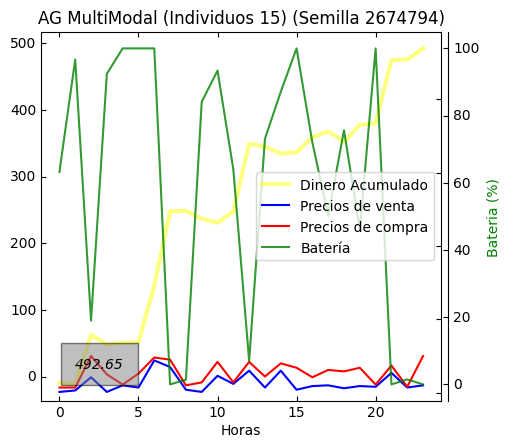

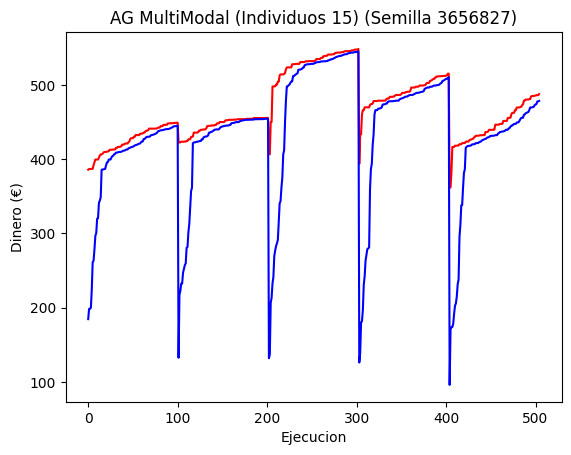

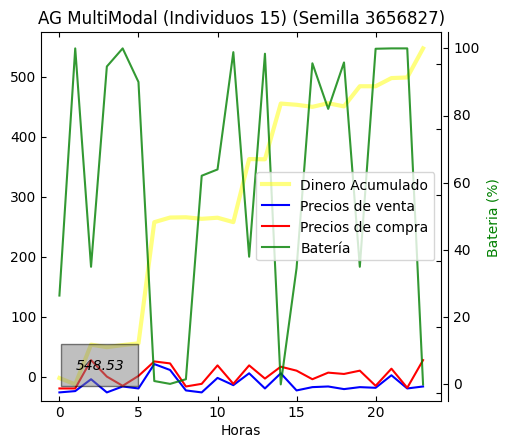

                 AG MultiModal
Ev. Medias                1580
Ev. Mejor                 1580
Ev. Desviación             0.0
Mejor €                 548.53
Media €                 509.95
Desviación €             21.39
Ev. Mejor Dinero        5: 302
Ev. Medias Mejor           100
Mejor valor: 548.5293897444609
Peor valor: 361.9700431149504


In [69]:
n_individuos= 15
max_iteraciones = 100
max_iteraciones_sin_mejora = 100
porcentaje_torneo = 0.4
prob_mutacion = 0.2
n_nicho = 5
radio = 5

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, n_nicho, prob_mutacion, radio]

algorithm_name = algoritmo_genetico_multimodal_name

# Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

# Data.append(mejor_data)

#### Genético Multimodal - Más individuos, más iteraciones

Se ha probado con 1000 iteraciones pero la gráfica de evaluación mostraba que apenas crecía y tardaba mucho. Por lo que 1000 iteraciones para el multimodal no es un buen valor ya que no se mejora lo suficiente como para que merezca la pena.

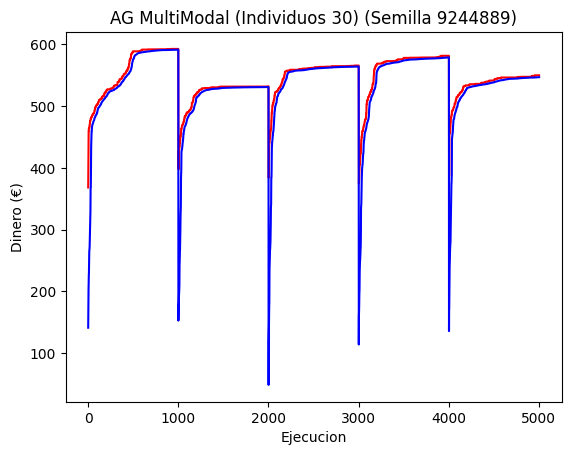

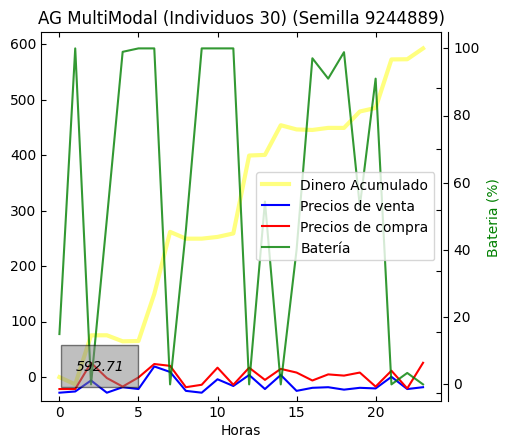

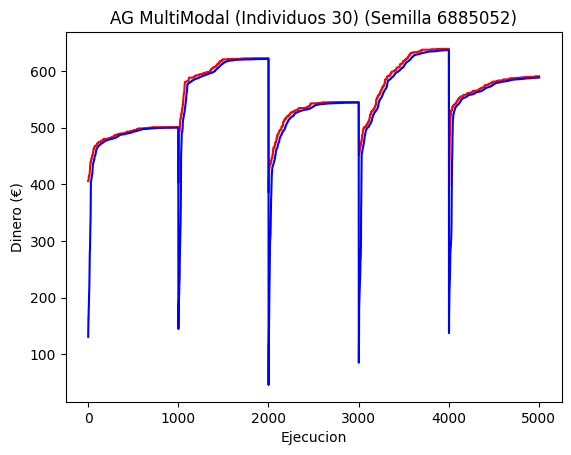

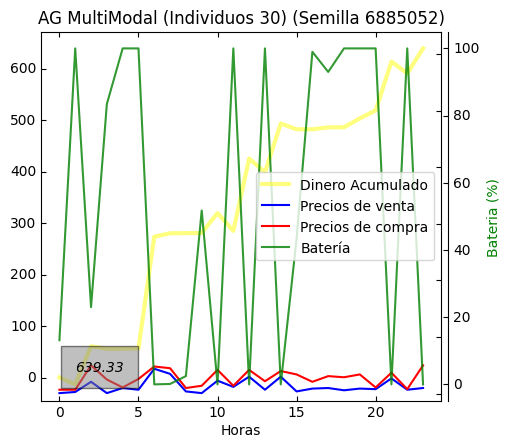

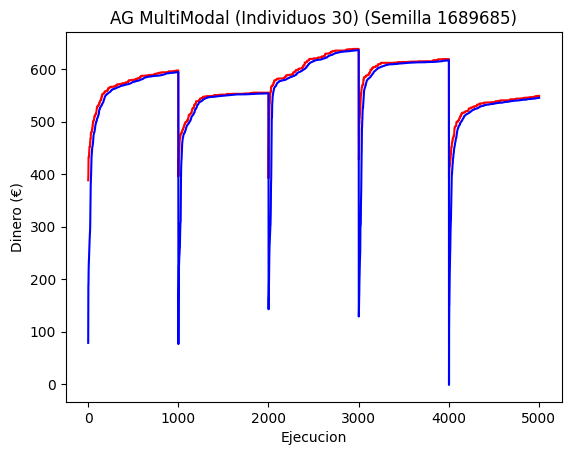

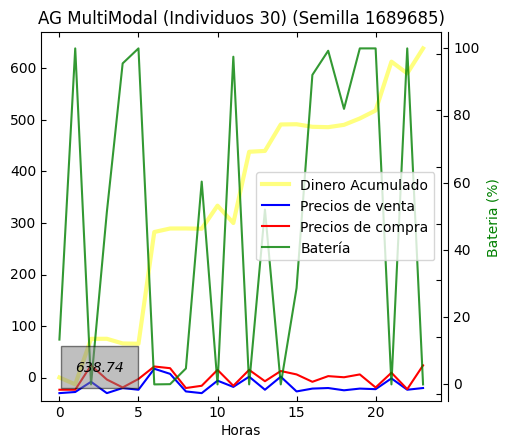

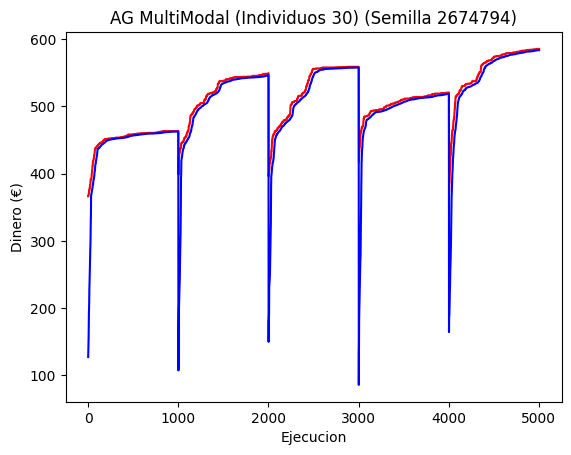

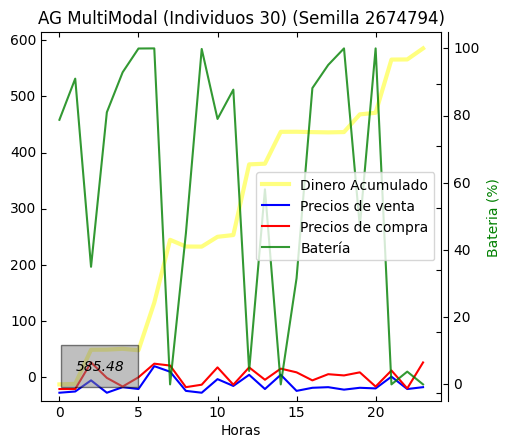

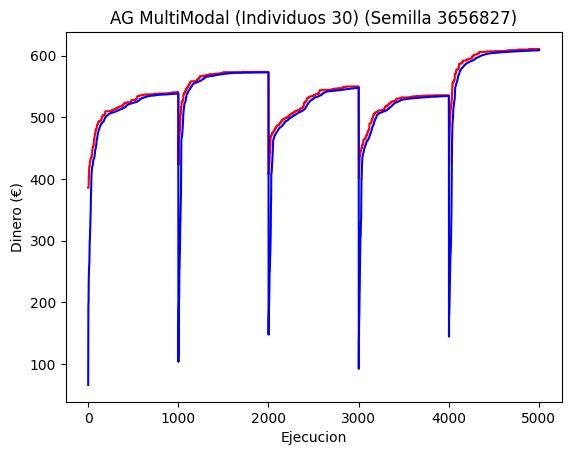

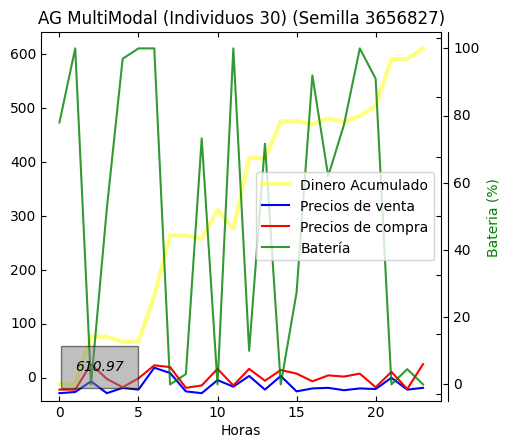

                 AG MultiModal
Ev. Medias               15155
Ev. Mejor                15155
Ev. Desviación             0.0
Mejor €                 639.33
Media €                 610.97
Desviación €             25.14
Ev. Mejor Dinero       2: 3930
Ev. Medias Mejor          3930
Mejor valor: 610.972928288
Peor valor: 385.94501840000004


In [70]:
n_individuos= 30
max_iteraciones = 1000
max_iteraciones_sin_mejora = float("inf")
porcentaje_torneo = 0.4
prob_mutacion = 0.2
n_nicho = 5
radio = 10

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, n_nicho, radio, prob_mutacion]

algorithm_name = algoritmo_genetico_multimodal_name

# Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

# Data.append(mejor_data)

#### Genético Multimodal Optimizado

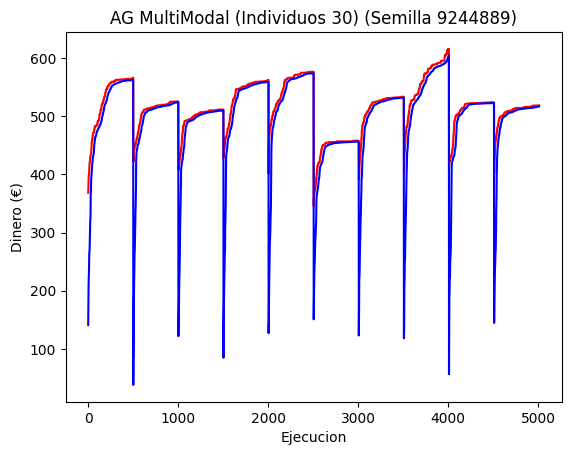

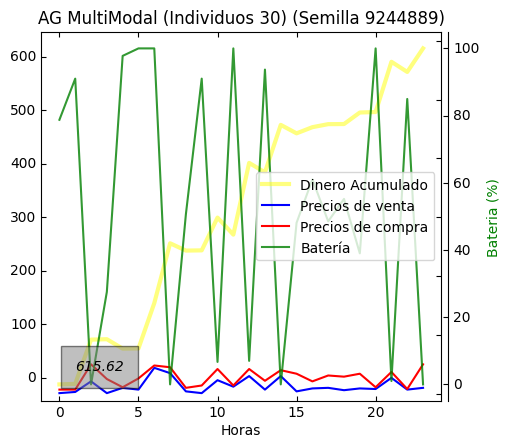

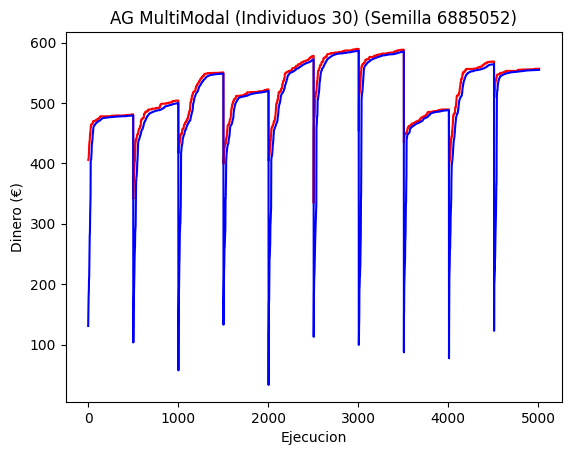

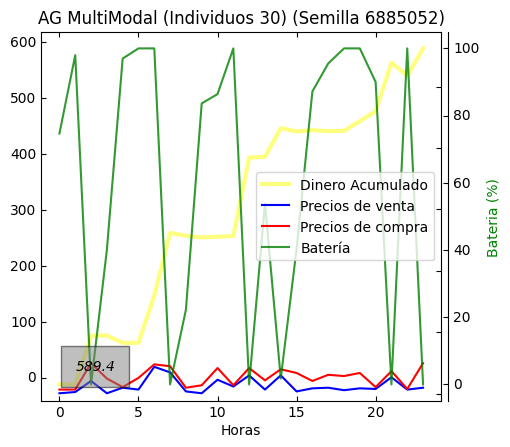

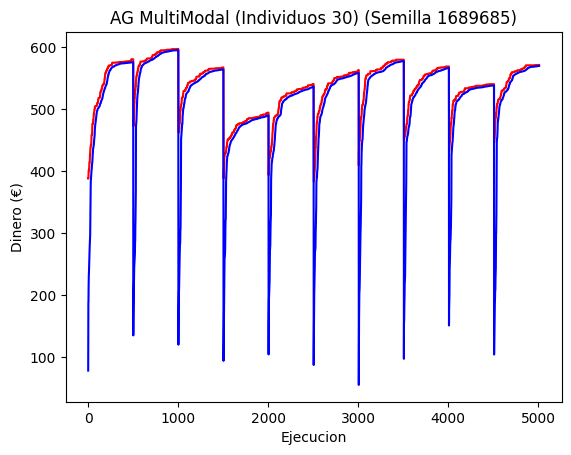

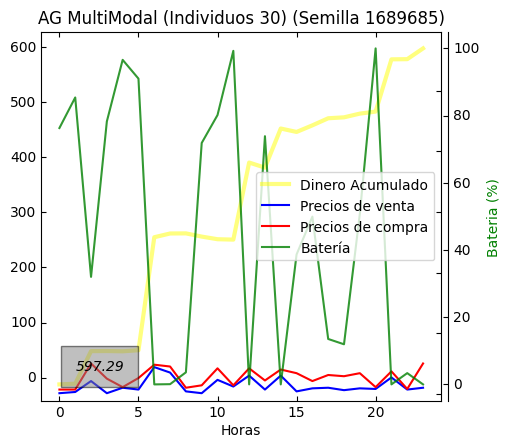

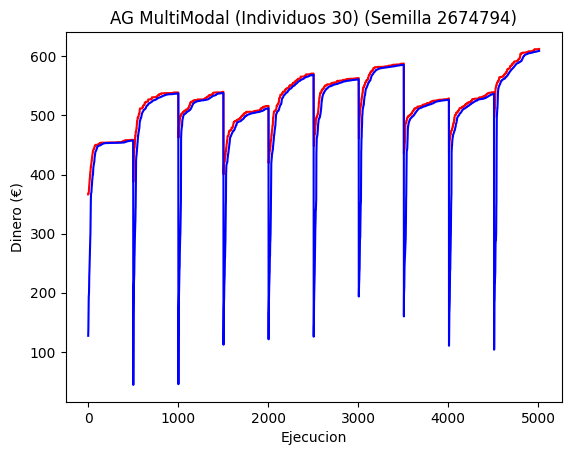

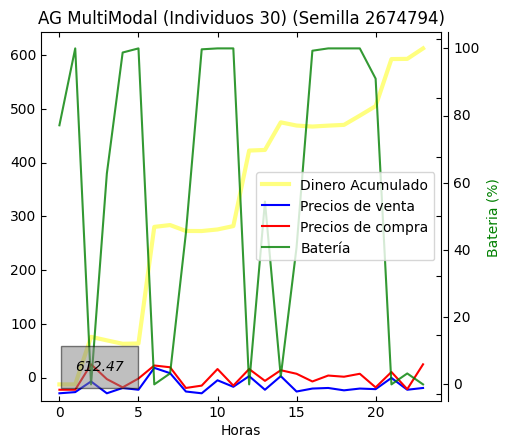

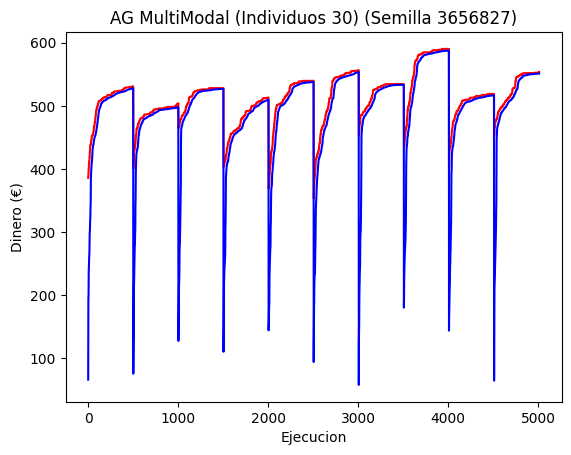

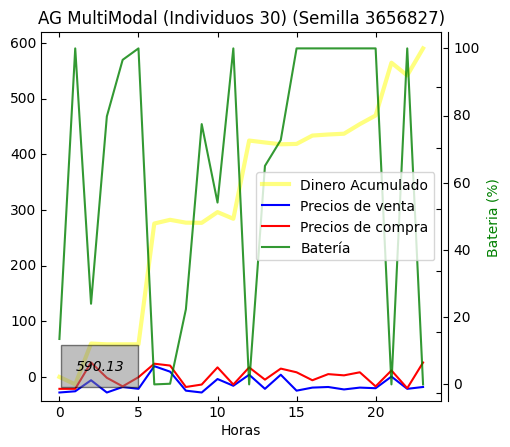

                 AG MultiModal
Ev. Medias               15310
Ev. Mejor                15310
Ev. Desviación             0.0
Mejor €                 615.62
Media €                 597.29
Desviación €             12.37
Ev. Mejor Dinero       1: 3998
Ev. Medias Mejor          3928
Mejor valor: 590.1281117691199
Peor valor: 353.1071631629376


In [71]:
n_individuos= 30
max_iteraciones = 500
max_iteraciones_sin_mejora = float("inf")
porcentaje_torneo = 0.8
prob_mutacion = 0.2
n_nicho = 10
radio = 20

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, n_nicho, radio, prob_mutacion]

algorithm_name = algoritmo_genetico_multimodal_name

Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(mejor_data)

## Resultados Finales

#### Problema 1

En este problema el mejor algoritmo ha resultado serel AG Básico, era de esperar que fuera el multimodal, pero a pesar de la capacidad alta de cómputo y tiempo que requiere su solución no ha resultado muy buena. El número de desviación de evaluaciones tan solo varía en el mejor, esto es porque finalmente se ha decidido quitar la condición extra de máximos iteraciones sin mejora, ya que tampoco es muy alto el tiempo de diferencia. Sin embargo en donde más se sufre este tiempo es en el multimodal.

Respecto a los resultados, todos son bastante robustos a excepción de El Mejor y el CHC. Tanto para el algoritmo de El Mejor como el multimodal la mejor solución es encotrada bastante pronto, se podría reducir el número máximo de iteraciones. Sin embargo, para el Básico y el CHC se han necesitado más iteraciones para encontrar la mejor solución.

Multimodal y el básico convergen mejor que el resto pues la desviación es muy baja.

Aún así, como en la práctica 1, para el problema 1 no se obtienen mejoras y diferencias muy grandes, esto puede deberse a la función evaluación elegida.

In [36]:
Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor €", "Ev. Medias Mejor"]

while len(Algorithms_names) < len(Header):
    Algorithms_names.append(0)
    Data.append([0,0,0,0,0,0,0,0])

import numpy as np

Data_copy = np.array(Data)

# print(pd.DataFrame(Data.transpose(), Header, column))

# ev_media, ev_mejor, ev_desviacion, euro_mejor, euro_media, euro_desviacion = v

format_row = "{:>16}" * (len(Header) + 1)
print(format_row.format("", *Algorithms_names))
for dat, row in zip(Header, Data_copy.transpose()):
    print(format_row.format(dat, *row))

                        El Mejor       AG Básico          AG CHC   AG MultiModal               0               0               0               0
      Ev. Medias            3025            6031           16031           15310               0               0               0               0
       Ev. Mejor            3013            6031           16031           15310               0               0               0               0
  Ev. Desviación             9.7             0.0             0.0             0.0               0               0               0               0
         Mejor €           332.2          331.11          317.66           330.1               0               0               0               0
         Media €           329.3          329.91          315.27          328.85               0               0               0               0
    Desviación €             8.4            0.72            1.55            1.69               0               0               0  

#### Problema 2

Para el problema 2 se han obtenido resultados más variados para los algoritmos. Siendo el que obtiene mejores resultados el básico, sería de esperar que el mejor fuera el multimodal pero al reducir el número máximo de iteraciones para evitar tiempos excesivos no ha alcanzado muy buenos resultados. Si se dispusiese de tiempo probablemente el multimodal obtuviese mejores resultados. Todos mejoran El Mejor a excepción de CHC, que para ambos problemas no obtiene buenos resultados. Como CHC se suele utilizar para problemas binarios, puede deberse a una mala adaptación del algoritmo para este problema.

Por otro lado entre el básico y el Multimodal la diferencia entre las mejores soluciones es bastante altas por lo que el tiempo y capacidad de cómputo del multimodal nos hace pensar si realmente merece la pena ejecutarlo ya que el básico con menos tiempo y evaluaciones obtiene mejores resultados. Esto dependerá del problema que queramos solucionar, en nuestro caso, tampoco ha requerido tanto tiempo por lo que aceptamos el multimodal. Esto lo podemos observar mejor con el número de evaluaciones. Mientras El Mejor apenas realiza evaluaciones el Mutimodal realiza muchas. CHC es el que más evaluaciones realiza y aún así tiene el peor resultado.

La desviación de las soluciones es baja respecto a los números que obtenemos, aunque el MultiModal, que es el que mejor solución obtiee es el que menos desviación muestra en la solución por lo que podríamos decir que es el algoritmo más robusto y que mejor converge.

Las mejores soluciones se encuentran aproximadamente a mitad de las evaluaciones en la mayoría de los casos, por lo que nos hace pensar que se está explorando el espacio solo que a partir de cierto momento no se obtienen buenos resultados.

In [72]:
Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor €", "Ev. Medias Mejor"]

while len(Algorithms_names) < len(Header):
    Algorithms_names.append(0)
    Data.append([0,0,0,0,0,0,0,0])

import numpy as np

Data_copy = np.array(Data)

# print(pd.DataFrame(Data.transpose(), Header, column))

# ev_media, ev_mejor, ev_desviacion, euro_mejor, euro_media, euro_desviacion = v

format_row = "{:>16}" * (len(Header) + 1)
print(format_row.format("", *Algorithms_names))
for dat, row in zip(Header, Data_copy.transpose()):
    print(format_row.format(dat, *row))

                        El Mejor       AG Básico          AG CHC   AG MultiModal               0               0               0               0
      Ev. Medias            3036            6031           16031           15310               0               0               0               0
       Ev. Mejor            3025            6031           16031           15310               0               0               0               0
  Ev. Desviación            6.22             0.0             0.0             0.0               0               0               0               0
         Mejor €          553.05          647.93          542.79          615.62               0               0               0               0
         Media €          535.49          628.77          503.45          597.29               0               0               0               0
    Desviación €           45.85           32.92           20.49           12.37               0               0               0  